In [1]:
# # # import all relevant libraries dependencies and set up the backend
# # import time
# # import IPython
# # import numpy as np
# # import matplotlib
# # import math
# # import pandas
# # import pickle
# # import subprocess
# # import matplotlib.pyplot as plt
# # %matplotlib inline

# # import scipy
# # import scipy.special 
# # import scipy.optimize
# # import scipy.sparse.linalg as LA
# # import scipy.sparse as sparse
# # from scipy.io import loadmat
# # from scipy.optimize import curve_fit
# # from scipy.signal import argrelextrema

# # # add the ED.py functions to the notebook
# # import sys
# # #import hubbard as ED 

# import numpy as np
# import time
# import scipy
# import scipy.special
# import scipy.sparse.linalg as LA
# import scipy.sparse as sparse
# import copy
# import warnings
# import matplotlib
# import matplotlib.pyplot as plt

# # dataframes
# import pandas
# import pickle
# import subprocess


# from matplotlib import animation, rc
# # rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':12})
# # rc('font',**{'family':'serif','serif':['FreeSerif'],'size':12})
# rc('text', usetex=True)
# from cycler import cycler

# c1_a = '#003AF0'
# c2_a = '#008F24'
# c3_a = '#FE7B22'
# c4_a = '#FE000C'
# c5_a = '#FB30F2'
# c6_a = '#82E0AA' #'#FFE135'
# c7_a = '#9966CC'
# c8_a = '#7FFFD4'
# c9_a = '#66FF00'
# c10_a = '#8B008B'
# c11_a = '#000000'
# colours = [c1_a,c2_a,c3_a,c4_a,c5_a,c6_a,c7_a,c8_a,c9_a,c10_a,c11_a]

# matplotlib.rcParams['backend'] = 'MacOSX'
# matplotlib.rcParams['savefig.dpi'] = 250
# matplotlib.rcParams['text.usetex'] = True
# # matplotlib.rcParams['text.latex.unicode']=True
# matplotlib.rcParams['axes.prop_cycle'] = cycler('color',colours)
# # matplotlib.rcParams['axes.'] = \in\
# # matplotlib.rcParams['legend.fancybox']=True
# matplotlib.rcParams['legend.frameon'] = False
# matplotlib.rcParams['legend.fontsize'] = 12
# matplotlib.rcParams['figure.figsize'] = (10,8)
# # matplotlib.rcParams['axes.color_cycle'] = colors
# # matplotlib.rcParams['axes.prop_cycle'] = colors

In [2]:
# import all relevant libraries, dependencies and set up the backend
import IPython
from qutip import *

import time
import numpy as np
import scipy
import scipy.special
import scipy.sparse.linalg as LA
import scipy.sparse as sparse
from scipy.io import loadmat

# fast exp(Matrix)*Vector multiplication using Krylov methods (Matlab's expokit)
from pyexpokit import expmv

import copy
import warnings
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
import pickle

import subprocess

# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# # add the ED.py functions to the notebook
# import sys
# # first add the path to ED.py to the python path
# sys.path.append('/Volumes/ExternalStorage/ipython')
# # import ED.py 
# import ED 
# import get_data as GD

from matplotlib import animation, rc
from cycler import cycler

# set up figure properties
matplotlib.rcParams['backend']='MacOSX'
matplotlib.rcParams["savefig.dpi"]=250
matplotlib.rcParams['text.usetex']=True
# colours
c1_a = '#003AF0'
c2_a = '#008F24'
c3_a = '#FE7B22'
c4_a = '#FE000C'
c5_a = '#FB30F2' #'#FFE135'
c6_a = '#8B008B'
c7_a = '#000000'
c8_a = '#9966CC'
c9_a = '#7FFFD4'
c10_a = '#66FF00'
c11_a = '#82E0AA' 
colours = [c1_a,c2_a,c3_a,c4_a,c5_a,c6_a,c7_a,c8_a,c9_a,c10_a,c11_a]
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', colours)
# legend
matplotlib.rcParams['legend.fancybox']=True
matplotlib.rcParams['legend.frameon']=False
#matplotlib.rcParams['legend.fontsize']=16
matplotlib.rcParams['figure.figsize'] = (8,6)
# font
rc('font',**{'family':'Dejavu sans', 'serif':['FreeSerif'], 'size':24})
rc('text', usetex=True)

# fontsize of the axes title
plt.rc('axes', titlesize=24)
# fontsize of the x and y labels
plt.rc('axes', labelsize=24)
# fontsize of the tick labels
plt.rc('xtick', labelsize=20)
# fontsize of the tick labels
plt.rc('ytick', labelsize=20)
# legend fontsize
plt.rc('legend', fontsize=16)
# fontsize of the figure title
plt.rc('figure', titlesize=24)

In [3]:
# all relevant helper functions for the ED
def state_to_int(p, statelist):
    """
    Converts array of spin-configuration into integer
    Args:
        p - dictionary that contains the relevant system parameters
        statelist - spin configuration (binary)
    Returns:
        out - integer corresponding to state
    """
    # convert statelist to string
    state = ''.join([str(s) for s in statelist])
    # construct unique integer for the fermion configuration defined
    # in statelist
    out = int(state,2)
    return out


def int_to_state(p, state_number):
    """
    Converts integer to array of spin-configuration
    Args:
        p - dictionary that contains the relevant system parameters
        state_number - integer corresponding to state
    Returns:
        statelist - fermion configuration
    """

    # convert integer to spin configuration of length L (binary representation)
    statelist = format(state_number,"0%sb"%(p['N']))
    # remove the 0b tag at the beginning
    statelist = [int(s) for s in statelist]
    return statelist


def generate_state_table(p):
    """
    generates table of state-integers of the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters
    Returns:
        state_table - list of all state_numbers that belong to the Hilbertspace
    """
    # generate list of state_numbers which are allowed by the symmetries
    state_table = []
    if p['Symmetry'] == None:
        # generate full Hilbert space
        for i in range(int(2**p['N'])):
            state_table.append(i)
    else:
        # Sz != None, i.e. choose specific symmetry sector
        for i in range(int(2**p['N'])):
            if np.sum(np.asarray(int_to_state(p, i)) - 0.5) == p['Symmetry']:
                state_table.append(i)
        
    return state_table
    

def transverse_field_matrix(p, state_table):
    """
    generates the full transverse field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        transverse_field - interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # iterate through the chain and flip each spin with application of X
        for i in range(len(state)):
            outstate = copy.deepcopy(state)
            
            # flip local spin (X)
            outstate[i] = 0 if outstate[i] else 1
            
            # get new state number
            Out = state_table.index(state_to_int(p, outstate))
            
            # get matrix element (note Sx = 1/2*X)
            matrixelement = -0.5 * p['hx']
            
            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)
            
            del matrixelement

    transverse_field = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return transverse_field


def longitudinal_field_matrix(p, state_table):
    """
    generates the full longitudinal field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        longitudinal_field - interaction matrix on the Hilbertspace
    """
        
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5

        # get matrix element
        matrixelement = -1.0 * p['hz'] * np.sum(spin)
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    longitudinal_field = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return longitudinal_field


def ZZinteraction_matrix(p, state_table):
    """
    generates the full ZZ interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        ZZ_interaction - ZZ interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5
            
        # multiply nearest neighbour ZZ interaction term
        ZiZj = spin[1:] * spin[:-1]
        
        # get matrix element
        matrixelement = -1.0 * p['Jz'] * np.sum(ZiZj)
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement, ZiZj
        
    ZZ_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return ZZ_interaction


def spinflip_matrix(p, state_table):
    """
    generates the full 0.5*(S(i,+)S(i+1,-) + S(i,-)S(i+1,+)) interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        spinflip_interaction - spinflip interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # iterate through the chain and swap adjacent spins if they are anti-alligned
        for i in range(len(state)-1):
            if state[i] != state[i+1]:
                outstate = copy.deepcopy(state)

                # swap spins and sites (i,i+1)
                outstate[i] = 0 if outstate[i] else 1
                outstate[i+1] = 0 if outstate[i+1] else 1

                # get new state number
                Out = state_table.index(state_to_int(p, outstate))

                # get matrix element
                matrixelement = -0.5 * p['Jx']

                # store matrix element
                row.append(Out)
                col.append(In)
                data.append(matrixelement)

                del matrixelement
        
    spinflip_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return spinflip_interaction


def longrange_spinflip_matrix(p, i, j, state_table):
    """
    generates the full (S(i,+)S(j,-) + S(i,-)S(j,+)) interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        i - site 1
        j - site 2
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        longrange_spinflip_interaction - spinflip interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # can only swap spins on sites (i,j) if they are 'anti-alligned'
        if state[i] != state[j]:
            outstate = copy.deepcopy(state)

            # swap spins and sites (i,i+1)
            outstate[i] = 0 if outstate[i] else 1
            outstate[j] = 0 if outstate[j] else 1

            # get new state number
            Out = state_table.index(state_to_int(p, outstate))

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    longrange_spinflip_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return longrange_spinflip_interaction


def make_Hamiltonian(p, state_table):
    """
    Generates full Hamiltonian on the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        H - Hamiltonian matrix on the full Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    H = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    H = longitudinal_field_matrix(p, state_table)
    if p['Symmetry'] == None:
        H += transverse_field_matrix(p, state_table)
    H += spinflip_matrix(p, state_table)
    H += ZZinteraction_matrix(p, state_table)

    return H


def calculate_gs(p):
    """
    calculates groundstate of full Hamiltonian on the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters for the GS search
    Returns:
        E0 - GS energy
        gs - GS vector on the relevant Hilbertspace subspace
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    state_table = generate_state_table(p)
    H = make_Hamiltonian(p, state_table)
    w, v = scipy.sparse.linalg.eigsh(H, k=1, which='SA')

    return w[0], v[:, 0], state_table


def expct_val(Op, psi):
    """
    compute expecation value of operator 'Op' with state 'psi'
    Args:
        Op - operator corresponding to observable to be measured
        psi - state-vector (on sub-Hilbertspace)
    Returns:
        <psi| Op |psi>
    """
    return (psi.conj().T).dot(Op.dot(psi))


def matrix_elements(Op, bra, ket):
    """
    compute matrix element of operator 'Op' with state 'bra' form the left and 'ket' from the right
    Args:
        Op - operator corresponding to observable to be measured
        bra - adjoint (left/outgoing) state
        ket - (right/incoming) state
    Returns:
        <bra| Op |ket>
    """
    return (bra.conj().T).dot(Op.dot(ket))


def Sz_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sz_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sz is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sz - Sz_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5

        matrixelement = spin[site]
        # store matrix element
        if matrixelement != 0.0:
            row.append(In)
            col.append(In)
            data.append(matrixelement)

        del matrixelement

    Sz = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sz


def Sx_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sx_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sx is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sx - Sx_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (Sx = 1/2*X) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_table.index(state_to_int(p, outstate))
            
        # get matrix element
        matrixelement = 0.5
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Sx = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sx


def Sy_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sy_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sy is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sy - Sy_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (Sy = 1/2*Y) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_table.index(state_to_int(p, outstate))
            
        # get matrix element (-i/2 if initially state = 0 else i/2)
        matrixelement = 0.5j if state[site] else -0.5j
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Sy = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sy


def Sp_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator S+_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which S+ is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Splus - S+_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
        
        if not(outstate[site]):
            # raise local spin (S+ = Sx + i Sy) at site
            outstate[site] = 1

            # get new state number
            Out = state_table.index(state_to_int(p, outstate))

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    Splus = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Splus


def Sm_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator S-_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which S- is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sminus - S-_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
        
        if outstate[site]:
            # lower local spin (S- = Sx - i Sy) at site
            outstate[site] = 0

            # get new state number
            Out = state_table.index(state_to_int(p, outstate))

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    Sminus = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sminus


def build_densitymatrix(psi):
    """
    build the density matrix from a pure state psi
    Args:
        psi - state-vector (on full Hilbertspace)
    Returns:
        rho = |psi><psi|
    """
    
    # reshape psi0 into vector form of dimension (dim,1)
    psi = np.reshape(psi, (len(psi),1))
    
    return psi.dot(psi.conj().T)


def purification(rho):
    """
    purify the density matrix into vector form
    Args:
        rho - density matrix (on  full Hilbertspace)
    Returns:
        rho_vec = |psi>|psi>
    """

    return rho.flatten(order='C')


def depurification(rho_vec):
    """
    depurify the density matrix vector back into density matrix shape
    Args:
        rho_vec - density matrix vector (on  full Hilbertspace)
    Returns:
        rho = |psi><psi|
    """
    
    # dimension of Hilbert space is sqrt of the vector size
    dim = int(np.sqrt(np.size(rho_vec)))
    return rho_vec.reshape(dim,dim)


def quantum_fisher_info(rho, op, tol):
    """
    compute the Quantum Fisher Information for operator op and density matrix rho
    Args:
        rho - density matrix (either in standard or purified form)
        op - measurement operator on the full Hilbert space
        tol - tolerance to check the purity of the density matrix and which eigenvalues to sum in the QFI
    Returns:
        QFI - Quantum Fisher Information
        purity - Purity of the density matrix. If purity=-1 we use the full QFI computation, 
                    else the variance for pure state
    """
    
    # if rho is in purified form, bring it to standard form
    if np.size(rho) == np.shape(rho)[0]:
        rho = depurification(rho)
    
    # check if rho is truly a square hermitian matrix with trace 1
    try:
        np.shape(rho)[0] == np.shape(rho)[1] and np.allclose(rho.conj().T, rho, rtol=0.0, atol=tol) and \
            np.trace(rho) == 1.0
    except AsymmetricMatrixError:
        print("Not a square density matrix")
    
    # check the purity of the state
    purity = np.trace(rho.dot(rho))
    
    # compute the quantum fisher information
    QFI = 0.
        
    # diagonalise rho and get eigenvalues and right eigenvectors
    Eval, rEvec = scipy.linalg.eigh(rho)
    for i in range(len(Eval)):
        for j in range(len(Eval)):
            if np.real(Eval[i] + Eval[j]) > tol:
                # only sum over at least one non-zero eigenvalue
                prefactor = 2 / np.real(Eval[i] + Eval[j]) * np.real(Eval[i] - Eval[j])**2
                QFI += prefactor * np.abs(matrix_elements(op, rEvec[:,i], rEvec[:,j]))**2
            else:
                continue

    return QFI, purity


def QuTiP_quantum_fisher_info(state, op, tol):
    """
    compute the Quantum Fisher Information for operator op and density matrix rho
    Args:
        rho - density matrix (either in standard or purified form)
        op - measurement operator on the full Hilbert space
        tol - tolerance to check the purity of the density matrix and which eigenvalues to sum in the QFI
    Returns:
        QFI - Quantum Fisher Information
        purity - Purity of the density matrix. If purity=-1 we use the full QFI computation, 
                    else the variance for pure state
    """
    
    if state.type == "ket":
        # QFI is 4 * Var(op)
        # QFI = 4 * (expect(op*op, state) - expect(op, state)**2)
        rho = state * state.dag()
    else:
        rho = state

    # compute the quantum fisher information
    QFI = 0.

    # diagonalise rho and get eigenvalues and right eigenvectors
    Eval, rEvec = rho.eigenstates() #scipy.linalg.eigh(rho)
    for i in range(len(Eval)):
        for j in range(len(Eval)):
            if np.real(Eval[i] + Eval[j]) > tol:
                # only sum over at least one non-zero eigenvalue
                prefactor = 2 / np.real(Eval[i] + Eval[j]) * np.real(Eval[i] - Eval[j])**2
                QFI += prefactor * np.abs(rEvec[i].dag() * op * rEvec[j])**2 
            else:
                continue

    return QFI


def build_LindbladMatrix(p):
    """
    build Lindblad matrix acting on purified density matrix
    Args:
        p - dictionary that contains the relevant system parameters
    Returns:
        L - Lindblad matrix on the (full * auxiliary) state space
    """

    # set up basis states and Hilbert space
    state_table = generate_state_table(p)
    dim = len(state_table)
    I = sparse.csr_matrix(np.eye(dim))
    
    # make Hamiltonian
    H = make_Hamiltonian(p, state_table)
    
    # make jump operators
    jump_op = {}
    for i in range(p['N']):
        # Sx
        if p['Symmetry'] == None and p['gamma_Sx'] != 0.0:
            jump_op['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table)
            
        # Sz
        jump_op['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table)
        
        # Splus
        if p['Symmetry'] == None and p['gamma_Sp'] != 0.0:
            jump_op['Sp(%s)' % (i)] = Sp_matrix(p, i, state_table)
            
        # Sminus
        if p['Symmetry'] == None and p['gamma_Sm'] != 0.0:
            jump_op['Sm(%s)' % (i)] = Sm_matrix(p, i, state_table)
    
    # build L
    L = -1j * sparse.kron(H, I) + 1j * sparse.kron(I, H.T)
    
    for op in jump_op:
        L += p['gamma_%s' % op[:2]] * sparse.kron(jump_op[op], (jump_op[op].conj().T).T)
        L += -0.5 * p['gamma_%s' % op[:2]] * sparse.kron((jump_op[op].conj().T).dot(jump_op[op]), I)
        L += -0.5 * p['gamma_%s' % op[:2]] * sparse.kron(I, ((jump_op[op].conj().T).dot(jump_op[op])).T)
        
    return L


def evolve_purification(p, state_table, rho0, kind="matrix", verbose=True):
    """
    evolve purified density matrix 'rho' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        state_table - list of all basis states (int) in the full Hilbert space
        rho - initial density matrix in purified form
        kind - how the state is passed to the function: 
                kind="list" spin-configuration (productstate) OR 
                kind="int" the unique state id in the state_table OR
                kind="matrix" (default) regular density matrix OR 
                kind="purified" the purified density matrix vector
    Returns:
        sim - dictionary with the relevant measurements: Sx, Sy, Sz, FI
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    
    if kind == "list":
        # if we parsed a product state, construct ket by identifying the
        # corresponding number of the basis state and putting a 1 into the ket
        # and then build density matrix and its purified form from it
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(state_to_int(p, rho0))] = 1.
        rho = build_densitymatrix(psi0)
    elif kind == "int":
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(rho)] = 1.
        rho = build_densitymatrix(psi0)
    elif kind == "matrix":
        rho = rho0
    elif kind == "purified":
        rho = depurification(rho0)

    Time = np.arange(start=p['t_initial'], stop=(p['t_final'] + p['dt']), step=p['dt'])

    # make dictionary with measurement operators
    meas = {}
    for i in range(int(p['N'])):
        if p['Symmetry'] == None:
            meas['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table).toarray()
            meas['Sy(%s)' % (i)] = Sy_matrix(p, i, state_table).toarray()
        meas['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table).toarray()
        # total spin
        if i == 0:
            if p['Symmetry'] == None:
                meas['Sx'] = meas['Sx(%s)' % (i)]
                meas['Sy'] = meas['Sy(%s)' % (i)]
            meas['Sz'] = meas['Sz(%s)' % (i)]
        else:
            if p['Symmetry'] == None:
                meas['Sx'] = meas['Sx'] + meas['Sx(%s)' % (i)]
                meas['Sy'] = meas['Sy'] + meas['Sy(%s)' % (i)]
            meas['Sz'] = meas['Sz'] + meas['Sz(%s)' % (i)]
    if p['Symmetry'] == None:
        meas['SxSx'] = meas['Sx'].dot(meas['Sx'])
        meas['SySy'] = meas['Sy'].dot(meas['Sy'])
    meas['SzSz'] = meas['Sz'].dot(meas['Sz'])
        
    sim = {}
    sim['Time'] = Time
    sim['Purity'] = np.zeros(np.shape(Time), dtype=complex)
    for key in meas.keys():
        sim[key] = np.zeros(np.shape(Time), dtype=complex)
        
    if p['Symmetry'] == None:
        sim['QFI_Sx'] = np.zeros(np.shape(Time), dtype=complex)
        sim['QFI_Sy'] = np.zeros(np.shape(Time), dtype=complex)
        sim['Var(Sx)'] = np.zeros(np.shape(Time), dtype=complex)
        sim['Var(Sy)'] = np.zeros(np.shape(Time), dtype=complex)
    sim['QFI_Sz'] = np.zeros(np.shape(Time), dtype=complex)
    sim['Var(Sz)'] = np.zeros(np.shape(Time), dtype=complex)

    # build Lindblad superoperator
    L = build_LindbladMatrix(p)
    
    # construct time-evolution operator
    # Eval, Evec = scipy.linalg.eig(L.toarray(), right=True)
    # U = Evec.dot(np.diag(np.exp(Eval*p['dt'])).dot(scipy.linalg.inv(Evec)))
    # expmv(p['dt'], L, rho)

    # Time Evolution
    tic = time.time()
    clock = 1
    for i in range(len(Time)):
        # add status update every ~ 10%
        if i == np.floor(clock * len(Time) / 10) and verbose:
            toc = time.time()
            print("t = %.3f/%.3f \t %.1f \t %.fs\n" % (i*p['dt'], p['t_final'], 100 * i / len(Time), toc - tic)) 
            clock += 1
            
        # measurements
        for operator in meas.keys():
            sim[operator][i] = np.trace(rho.dot(meas[operator]))
        
        if p['Symmetry'] == None:
            sim['QFI_Sx'][i] = quantum_fisher_info(rho, meas['Sx'], tol=p['tol'])[0]
            sim['QFI_Sy'][i] = quantum_fisher_info(rho, meas['Sy'], tol=p['tol'])[0]
            sim['Var(Sx)'][i] = np.trace(rho.dot(meas['SxSx'])) - (sim['Sx'][i])**2
            sim['Var(Sy)'][i] = np.trace(rho.dot(meas['SySy'])) - (sim['Sy'][i])**2
        sim['QFI_Sz'][i], sim['Purity'][i] = quantum_fisher_info(rho, meas['Sz'], tol=p['tol'])
        sim['Var(Sz)'][i] = np.trace(rho.dot(meas['SzSz'])) - (sim['Sz'][i])**2

        # apply U to current state rho to get rho(t+dt) = U * rho(t)
        rho_vec = purification(rho)
        rho_vec = expmv(p['dt'], L, rho_vec.reshape(np.size(rho_vec))) #U.dot(rho_vec)
        rho = depurification(rho_vec)
        
    return sim, state_table


def jump_time(p, norm2_left, norm2_centre, norm2_right, eta):
    """
    compute the (numerically) exact time (in the interval [t,t+dt]) where the quantum jump occurs
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        norm2_left - || psi(t)||^2
        norm2_centre - || psi(t+dt/2)||^2
        norm2_right - || psi(t+dt)||^2
        eta - random number for which we want to find the intersection with the quaratic parabola
    Returns:
        T - dimensionless Time (in interval [t,t+dt]/dt ~ [0,1] ) where the jump occurs (up to 2nd order exact)
    """
    
    # fit parabola to 3 norms at [0, dt/2, dt]: norm^2(t) = at^2 + bt + c 
    
    # t = 0: psi = psi0
    # norm2_left = (psi.conj().T).dot(psi)
    
    # t = dt/2: psi = U(dt/2) * psi0
    # U = LA.expm(-1.j * Heff.tocsc() * p['dt'] / 2.)
    # psi = U.dot(psi0)
    # norm2_centre = (psi.conj().T).dot(psi)
    
    # t = dt: psi = phi = U(dt)*psi0
    # norm2_right = (phi.conj().T).dot(phi)
    
    # get coefficients
    a = 2 * (norm2_right - 2 * norm2_centre + norm2_left) # / (p['dt']**2)
    b = (4 * norm2_centre - norm2_right - 3 * norm2_left) # / p['dt']
    c = norm2_left
    
    # now solve norm^2(t) = at^2 + bt + c == eta
    sol1 = (-b + np.sqrt(b**2 + 4 * a * (eta - c))) / (2 * a)
    sol2 = (-b - np.sqrt(b**2 + 4 * a * (eta - c))) / (2 * a)
    
    # solution MUST be in the interval [0, dt]/dt = [0,1] if both are valid, then take the smaller one
    if sol1 >= 0.0 and sol1 <= 1.0: # p['dt']:
        # sol1 is viable solution, check sol2
        if sol2 >= 0.0 and sol2 <= 1.0: # p['dt']:
            # sol2 is also a viable solution, return the smaller one of the two
            return np.min([sol1, sol2])
        else:
            # sol2 is NOT a viable solution, sol1 only solution
            return sol1
    else:
        # sol1 is NOT viable solution, check sol2
        if sol2 >= 0.0 and sol2 <= 1.0: #p['dt']:
            # sol2 is the only viable solution
            return sol2
        else:
            # both solutions aren't valid, give error
            print("Error: No viable solution found where jump should occur")
            print(norm2_left, norm2_centre, norm2_right, eta)
            return NaN
        
        
def apply_jump(p, jump_op, psi):
    """
    apply the correct jump operator sampling from the cumulative jump distribution 
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        jump_op - dictionary of all possible/allowed jump operators
        psi - current state vector psi(t-)
    Returns:
        psi - state vector after jump is applied psi(t+)
    """
    
    # generate jump probability distribution
    jump_probability = np.empty(0) 
    for op in jump_op:
        if p['gamma_%s' % op[:2]] == 0.0:
            continue
        else:
            expct = expct_val((jump_op[op].conj().T).dot(jump_op[op]), psi)
            if np.imag(expct) > 1e-20:
                print("Error: imaginary measurement of jump probability")
            else:
                expct = np.real(expct)
            # instant jump probability only proportional to dt so can remove to make it explicitly
            # independent of time-step dt
            # jump_probability = np.append(jump_probability, p['dt'] * p['gamma_%s' % op[:2]] * expct)
            jump_probability = np.append(jump_probability, p['gamma_%s' % op[:2]] * expct)

    # normalise probability distribution
    jump_probability = jump_probability / np.sum(jump_probability)

    # build cumulative jump probability
    cumulative_probability = np.zeros(np.shape(jump_probability))
    for n in range(len(jump_probability)):
        if n == 0:
            cumulative_probability[n] = jump_probability[n]
        else:
            cumulative_probability[n] = cumulative_probability[n-1] + jump_probability[n]


    # draw random number and its associated jump_operator
    pi = np.random.rand(1)[0]
    jump_index = np.where(cumulative_probability > pi)[0][0]

    # apply corresponding jump operator
    index = 0
    for op in jump_op:
        if p['gamma_%s' % op[:2]] == 0.0:
            # only count the jump operators which have non-zero dissipation rate
            continue
        else:
            if index == jump_index:
                # apply jump operator, normalise, and exit the loop
                psi = jump_op[op].dot(psi)
                psi = psi / np.sqrt((psi.conj().T).dot(psi))
                break
            index += 1
            
    return psi
        
    
def evolve_single_trajectory(p, state_table, psi0, kind="vector", verbose=True):
    """
    evolve purified density matrix 'rho' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        state_table - list of all basis states (int) in the full Hilbert space
        psi0 - initial state
        kind - how the state is passed to the function: 
                kind="list" spin-configuration (productstate) OR 
                kind="int" the unique state id in the state_table OR
                kind="vector" (default) state vector on full Hilbert space
    Returns:
        sim - dictionary with the relevant measurements: Sx, Sy, Sz, FI
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    
    if kind == "list":
        # if we parsed a product state, construct ket by identifying the
        # corresponding number of the basis state and putting a 1 into the ket
        # and then build density matrix and its purified form from it
        psi = np.zeros((len(state_table), 1), dtype=complex)
        psi[state_table.index(state_to_int(p, psi0))] = 1.
    elif kind == "int":
        psi = np.zeros((len(state_table), 1), dtype=complex)
        psi[state_table.index(psi0)] = 1.
    elif kind == "vector":
        psi = psi0
    
    # build time array
    Time = np.arange(start=p['t_initial'], stop=(p['t_final'] + p['dt']), step=p['dt'])

    # make dictionary with measurement operators
    meas = {}
    for i in range(int(p['N'])):
        if p['Symmetry'] == None:
            meas['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table).toarray()
            meas['Sy(%s)' % (i)] = Sy_matrix(p, i, state_table).toarray()
        meas['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table).toarray()
        # total spin
        if i == 0:
            if p['Symmetry'] == None:
                meas['Sx'] = meas['Sx(%s)' % (i)]
                meas['Sy'] = meas['Sy(%s)' % (i)]
            meas['Sz'] = meas['Sz(%s)' % (i)]
        else:
            if p['Symmetry'] == None:
                meas['Sx'] = meas['Sx'] + meas['Sx(%s)' % (i)]
                meas['Sy'] = meas['Sy'] + meas['Sy(%s)' % (i)]
            meas['Sz'] = meas['Sz'] + meas['Sz(%s)' % (i)]
    if p['Symmetry'] == None:
        meas['SxSx'] = meas['Sx'].dot(meas['Sx'])
        meas['SySy'] = meas['Sy'].dot(meas['Sy'])
    meas['SzSz'] = meas['Sz'].dot(meas['Sz'])
        
    sim = {}
    sim['Time'] = Time
    sim['Norm'] = np.zeros(shape=(len(Time)+1,), dtype=complex)
    sim['Purity'] = np.zeros(np.shape(Time), dtype=complex)
    for key in meas.keys():
        sim[key] = np.zeros(np.shape(Time), dtype=complex)
        
    if p['Symmetry'] == None:
        sim['QFI_Sx'] = np.zeros(np.shape(Time), dtype=complex)
        sim['QFI_Sy'] = np.zeros(np.shape(Time), dtype=complex)
        sim['Var(Sx)'] = np.zeros(np.shape(Time), dtype=complex)
        sim['Var(Sy)'] = np.zeros(np.shape(Time), dtype=complex)
    sim['QFI_Sz'] = np.zeros(np.shape(Time), dtype=complex)
    sim['Var(Sz)'] = np.zeros(np.shape(Time), dtype=complex)

    # build Hamiltonian
    H = make_Hamiltonian(p, state_table)
    
    # make jump operators
    jump_op = {}
    for i in range(p['N']):
        # Sx
        if p['Symmetry'] == None and p['gamma_Sx'] != 0.0:
            jump_op['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table)
            
        # Sy
        if p['Symmetry'] == None and p['gamma_Sy'] != 0.0:
            jump_op['Sy(%s)' % (i)] = Sy_matrix(p, i, state_table)
            
        # Sz
        if p['gamma_Sz'] != 0.0:
            jump_op['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table)
        
        # Splus
        if p['Symmetry'] == None and p['gamma_Sp'] != 0.0:
            jump_op['Sp(%s)' % (i)] = Sp_matrix(p, i, state_table)
            
        # Sminus
        if p['Symmetry'] == None and p['gamma_Sm'] != 0.0:
            jump_op['Sm(%s)' % (i)] = Sm_matrix(p, i, state_table)
    
    # build Heff
    Heff = H
    for op in jump_op:
        Heff += -0.5j * p['gamma_%s' % op[:2]] * (jump_op[op].conj().T).dot(jump_op[op])
    
    # construct time-evolution operator
    # expmv(p['dt'], -1.j * Heff, psi)
    # Ueff = LA.expm(-1.j * Heff.tocsc() * p['dt'])
    # Ueff_half = LA.expm(-1.j * Heff.tocsc() * p['dt'] / 2.)
    # Ueff = scipy.sparse.identity(np.size(psi)) - 1.j * p['dt'] * Heff

    # Time Evolution
    tic = time.time()
    clock = 1
    # choose random number eta to establish when to apply the next jump
    eta = np.random.rand(1)[0]
    for i in range(len(Time)):
        # add status update every ~ 10%
        if i == np.floor(clock * len(Time) / 10) and verbose:
            toc = time.time()
            print("t = %.3f/%.3f \t %.1f \t %.fs\n" % (i*p['dt'], p['t_final'], 100 * i / len(Time), toc - tic)) 
            clock += 1
        
        # measurements
        for operator in meas.keys():
            sim[operator][i] = expct_val(meas[operator], psi)
        
        if p['Symmetry'] == None:
            sim['QFI_Sx'][i] = quantum_fisher_info(build_densitymatrix(psi), meas['Sx'], tol=p['tol'])[0]
            sim['QFI_Sy'][i] = quantum_fisher_info(build_densitymatrix(psi), meas['Sy'], tol=p['tol'])[0]
            # CAUTION: This is only the variance for a particular trajector, 
            # NOT the same as the variance of the MC averaged quantity!!!
            sim['Var(Sx)'][i] = expct_val(meas['SxSx'], psi) - (sim['Sx'][i])**2
            sim['Var(Sy)'][i] = expct_val(meas['SySy'], psi) - (sim['Sy'][i])**2
        sim['QFI_Sz'][i], sim['Purity'][i] = quantum_fisher_info(build_densitymatrix(psi), \
                                                                 meas['Sz'], tol=p['tol'])
        sim['Var(Sz)'][i] = expct_val(meas['SzSz'], psi) - (sim['Sz'][i])**2

        
        # stochastic unravelling of the master equation: check norm of phi = psi(t+dt) = Ueff * psi(t)
        phi = expmv(p['dt'], -1.j * Heff, psi.reshape(np.size(psi))) # Ueff.dot(psi)
        phi = np.reshape(phi, (len(state_table), 1))
        
        # keep track of norm
        if i == 0:
            # initialise the norm at the first time-step
            sim['Norm'][i] = np.sqrt((psi.conj().T).dot(psi))
            
        # compute norm of potential future (next) time-step
        sim['Norm'][i+1] = sim['Norm'][i] * np.sqrt((phi.conj().T).dot(phi))

        # jump or don't jump ...
        if np.real(sim['Norm'][i+1]**2) <= eta:
            # (A) if current norm^2 <= eta, we find *exactly* where in the dt interval the jump occurs
            # and apply the the quantum jump *AT THIS INSTANCE* (i.e. no dt involved)
            # should also (hopefully) work if multiple jumps occur in a single time step
            
            # Setup LEFT: psi_left = psi(tleft) => norm2_left
            tleft = 0.0
            psi_left = psi
            norm2_left = np.real(sim['Norm'][i])**2
            # Setup RIGHT: psi_right = psi(tright) = phi => norm2_right
            tright = p['dt']
            psi_right = phi
            norm2_right = np.real(sim['Norm'][i+1])**2
            
            # find where and then apply quantum jump(s) until final norm is 
            # LARGER than eta (s.t. we can move on to next time step)
            num_jumps = 0
            while norm2_right <= eta:
                # get square of norm in the centre @ tcentre 
                # CAUTION: Need to evolve psi_left with correct norm, so multiply in norm_left by hand!
                tcentre = (tright + tleft) / 2.
                psi_centre = expmv(tcentre - tleft, -1.j * Heff, \
                                   np.sqrt(norm2_left) * psi_left.reshape(np.size(psi_left)))
                psi_centre = np.reshape(psi_centre, (len(state_table), 1))
                norm2_centre = np.real((psi_centre.conj().T).dot(psi_centre))
                
                # find T where jump occurs (rescale by interval window [tright-tleft] and shift by tleft!)
                T = jump_time(p, norm2_left, norm2_centre, norm2_right, eta) * (tright - tleft) + tleft
                tjump = T[0][0]
                
                # evolve up to jump (only need DURATION, i.e. tjump - tleft). This becomes new psi_left
                # CAUTION: Need to evolve psi_left with correct norm, so multiply in norm_left by hand!
                psi_left = expmv(tjump - tleft, -1.j * Heff, \
                                 np.sqrt(norm2_left) * psi_left.reshape(np.size(psi_left)))
                
                # apply jump, this becomes new psi_left and tleft <= tjump
                psi_left = apply_jump(p, jump_op, psi_left)
                norm2_left = np.real((psi_left.conj().T).dot(psi_left)) # should be equal to 1 as we jumped!
                tleft = tjump
                num_jumps += 1
                
                # evolve up to tright (FROM tjump, i.e. tright - tjump)
                # Actually, DON'T need to evolve psi_left with norm explicitly, since it should be 1 after jump!
                psi_right = expmv(tright - tjump, -1.j * Heff, \
                                  np.sqrt(norm2_left) * psi_left.reshape(np.size(psi_left)))
                norm2_right = np.real((psi_right.conj().T).dot(psi_right))
                tright = p['dt'] # right edge of interval doesn't move, fixed at time step (i+1)

                # redraw random number and hope to be finally out of this loop!
                eta = np.random.rand(1)[0]
                      
            # normalise
            psi = psi_right
            sim['Norm'][i+1] = np.sqrt((psi.conj().T).dot(psi))  
            
            if num_jumps > 1:
                # just to see how often we have more than one jump within a single time-step....should be seldom!
                print("t = %.3f, i=%i, number of jumps = %i" % (i*p['dt'], i, num_jumps))
        else:           
            # (B) apply Ueff to current state psi to get phi = psi(t+dt) = Ueff * psi(t)
            psi = phi / np.sqrt((phi.conj().T).dot(phi))
        
    return sim, state_table


def MonteCarloScheduler(p, state_table, psi0, kind="vector", verbose=True):
    """
    evolve purified density matrix 'rho' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        state_table - list of all basis states (int) in the full Hilbert space
        psi0 - initial state
        kind - how the state is passed to the function: 
                kind="list" spin-configuration (productstate) OR 
                kind="int" the unique state id in the state_table OR
                kind="vector" (default) state vector on full Hilbert space
    Returns:
        sim - dictionary with the relevant measurements: Sx, Sy, Sz, FI
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    
    sim = {}
    tic = time.time()
    clock = 1
    for i in range(p['MCSamples']):
        # add status update every ~ 10%
        if i == np.floor(clock * p['MCSamples'] / 10) and verbose:
            toc = time.time()
            print("#MCs = %i/%i \t %.1f \t %.fs\n" % (i, p['MCSamples'], 100 * i / p['MCSamples'], toc - tic)) 
            clock += 1
            
        # give ETA for first trajectory
        if verbose and i == 0:
            verbose_trajectory = True
        else:
            verbose_trajectory = False
            
        sample, state_table = evolve_single_trajectory(p=p, state_table=state_table, psi0=psi0, \
                                                       kind=kind, verbose=verbose_trajectory)
        
        # store all trajectory measurements (for now)
        for key in sample:
            if key == 'Time':
                if i == 0:
                    # don't forget adding the Time vector
                    sim[key] = sample[key]
                else:
                    continue
            else:
                if i == 0:
                    sim[key] = np.zeros((p['MCSamples'], len(sample[key])), dtype=complex)
                sim[key][i,:] = sample[key]
                
        
    
    for key in sample:
        if key == 'Time':
            continue
        else:
            # Monte-Carlo average
            average = np.sum(sim[key], axis=0) / p['MCSamples']
            # Monte-Carlo variance
            if p['MCSamples'] > 1:
                variance = np.sum(np.square(sim[key]), axis=0) / (p['MCSamples'] * (p['MCSamples'] - 1)) - \
                            np.square(average) / (p['MCSamples'] - 1)
            else:
                variance = np.zeros(np.shape(average))
                
            sim['%s_MCav' % (key)] = average
            sim['%s_MCsd' % (key)] = np.sqrt(variance)
    
    return sim, state_table

### Test 1: XX Model from single domainwall propagation

In [164]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 8 # system size
p['Symmetry'] = 0.0 # restrict to symmetry sector
p['hx'] = 0.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 0.0 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.005 # time step
p['t_final'] = 5.0
p['verbose'] = True

# Monte-Carlo samples
p['MCSamples'] = 1

In [165]:
# Quantum Trajectory Evolution
tic = time.time()
state_table = generate_state_table(p)
print("Size of Hilbert space = %i = %i" % (len(state_table), scipy.special.binom(p['N'], int(p['N']/2))))
# start with domain wall ...11110000...
psi0 = [1, 1, 1, 1, 0, 0, 0, 0]
mcwf, state_table = MonteCarloScheduler(p, state_table, psi0, kind="list", verbose=p['verbose'])
toc = time.time()
print("MCWF evolution took ", toc-tic, "s")

Size of Hilbert space = 70 = 70
#MCs = 0/1 	 0.0 	 0s

t = 0.500/5.000 	 10.0 	 2s

t = 1.000/5.000 	 20.0 	 5s

t = 1.500/5.000 	 30.0 	 8s

t = 2.000/5.000 	 40.0 	 12s

t = 2.500/5.000 	 50.0 	 17s

t = 3.000/5.000 	 59.9 	 22s

t = 3.500/5.000 	 69.9 	 28s

t = 4.000/5.000 	 79.9 	 35s

t = 4.500/5.000 	 89.9 	 41s

MCWF evolution took  48.7612099647522 s


In [166]:
# Purification Evolution
tic = time.time()
pure, state_table = evolve_purification(p, state_table, psi0, kind="list", verbose=p['verbose'])
toc = time.time()
print("Purification evolution took ", toc-tic, "s")

t = 0.500/5.000 	 10.0 	 9s

t = 1.000/5.000 	 20.0 	 18s

t = 1.500/5.000 	 30.0 	 27s

t = 2.000/5.000 	 40.0 	 38s

t = 2.500/5.000 	 50.0 	 49s

t = 3.000/5.000 	 59.9 	 62s

t = 3.500/5.000 	 69.9 	 75s

t = 4.000/5.000 	 79.9 	 89s

t = 4.500/5.000 	 89.9 	 102s

Purification evolution took  116.23544907569885 s


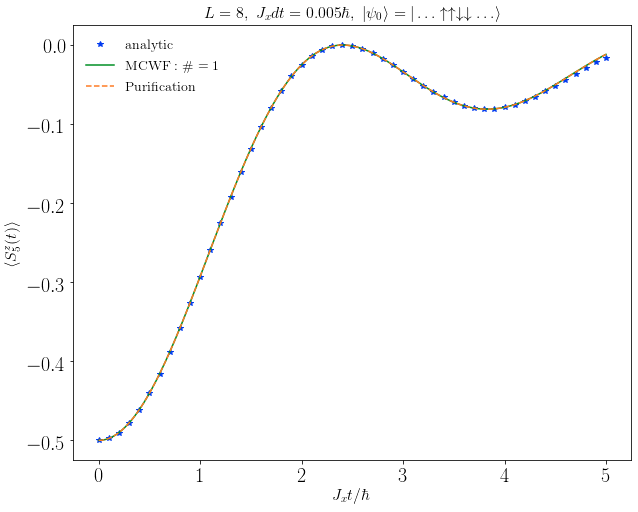

In [171]:
# https://arxiv.org/pdf/cond-mat/0409692.pdf 
# Eq. (4)
sites = np.arange(start=0, stop=p['N'], step=1) - int(p['N']/2 - 1)
i = int(p['N']/2) + 0
for order in range(sites[i]):
    if order == 0:
        analytics = -0.5 * scipy.special.jn(order, mcwf['Time'])**2
    else:
        analytics += -0.5 * scipy.special.jn(order, mcwf['Time'])**2
        analytics += -0.5 * scipy.special.jn(-order, mcwf['Time'])**2

# plot
fig= plt.figure(figsize=(10,8))
plt.plot(mcwf['Time'][::20], analytics[::20], '*', label=r'$\rm{analytic}$')
plt.plot(mcwf['Time'], np.real(mcwf['Sz(%i)_MCav' % (i)]), '-', \
         label=r'$\rm{MCWF:} ~ \# = %s$' % (p['MCSamples']))
plt.plot(pure['Time'], np.real(pure['Sz(%i)' % (i)]), '--', \
         label=r'$\rm{Purification}$')

plt.xlabel('$ J_{x}t/\hbar $', fontsize=16)
plt.ylabel(r'$\langle S^{z}_{%i}(t) \rangle$' % (i+1), fontsize=16)
plt.legend(loc=2, fontsize=14);
plt.title(r'$L=%i, ~ J_{x}dt = %.3f \hbar, ~ $' % (p['N'],p['dt']) + \
          r'$|\psi_{0}\rangle = |\dots\uparrow\uparrow\downarrow\downarrow\dots\rangle$', fontsize=16);
plt.savefig('Test1_XXModel_HamiltonianDynamics_L%i_Sz_Site%i.pdf' % (p['N'], i+1))

### Test 2: Single Spin driving with spontaneous emmision noise

In [137]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 1 # system size
p['Symmetry'] = None # full Hilbert space
p['hx'] = -1.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 0.0 # (global) spin-flip coupling
p['Jz'] = 0.0 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 1/6.
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.01 # time step
p['t_final'] = 15.0
p['verbose'] = True

# Monte-Carlo samples
p['MCSamples'] = 500

In [138]:
# Quantum Trajectory Evolution
tic = time.time()
state_table = generate_state_table(p)
# start in down
psi0 = [0]
mcwf, state_table = MonteCarloScheduler(p, state_table, psi0, kind="list", verbose=p['verbose'])
toc = time.time()
print("MCWF evolution took ", toc-tic, "s")

t = 1.500/15.000 	 10.0 	 0s

t = 3.000/15.000 	 20.0 	 1s

t = 4.500/15.000 	 30.0 	 1s

t = 6.000/15.000 	 40.0 	 1s

t = 7.500/15.000 	 50.0 	 2s

t = 9.000/15.000 	 60.0 	 2s

t = 10.500/15.000 	 70.0 	 2s

t = 12.000/15.000 	 79.9 	 3s

t = 13.500/15.000 	 89.9 	 3s

#MCs = 50/500 	 10.0 	 152s

#MCs = 100/500 	 20.0 	 303s

#MCs = 150/500 	 30.0 	 453s

#MCs = 200/500 	 40.0 	 604s

#MCs = 250/500 	 50.0 	 754s

#MCs = 300/500 	 60.0 	 905s

#MCs = 350/500 	 70.0 	 1056s

#MCs = 400/500 	 80.0 	 1226s

#MCs = 450/500 	 90.0 	 1435s

MCWF evolution took  1596.5814571380615 s


In [139]:
# Purification Evolution
tic = time.time()
pure, state_table = evolve_purification(p, state_table, psi0, kind="list", verbose=p['verbose'])
toc = time.time()
print("Purification evolution took ", toc-tic, "s")

t = 1.500/15.000 	 10.0 	 0s

t = 3.000/15.000 	 20.0 	 1s

t = 4.500/15.000 	 30.0 	 1s

t = 6.000/15.000 	 40.0 	 1s

t = 7.500/15.000 	 50.0 	 2s

t = 9.000/15.000 	 60.0 	 2s

t = 10.500/15.000 	 70.0 	 3s

t = 12.000/15.000 	 79.9 	 3s

t = 13.500/15.000 	 89.9 	 3s

Purification evolution took  3.68186092376709 s


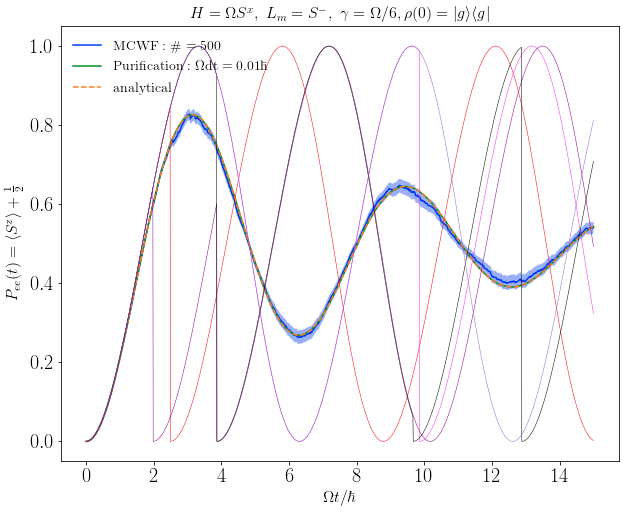

In [143]:
# plot
fig= plt.figure(figsize=(10,8))
plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)_MCav']) + 0.5, label=r'$\rm{MCWF:} ~ \# = %s$' % (p['MCSamples']))
plt.fill_between(mcwf['Time'], \
                 np.real(mcwf['Sz(0)_MCav']) + 0.5 - np.real(mcwf['Sz(0)_MCsd']), \
                 np.real(mcwf['Sz(0)_MCav']) + 0.5 + np.real(mcwf['Sz(0)_MCsd']), alpha=0.4)
plt.plot(pure['Time'], np.real(pure['Sz(0)'] + 0.5), '-', \
         label=r'$\rm{Purification:} ~ \Omega dt = %.2f \hbar$' % (p['dt']))
Omega = np.sqrt(p['hx']**2 - (p['gamma_Sm']/4)**2)
amplitude = p['hx']**2 / (p['gamma_Sm']**2 + 2*p['hx']**2)
oscillations = np.cos(Omega * pure['Time']) + (3*p['gamma_Sm']/(4*Omega)) * np.sin(Omega * pure['Time'])
plt.plot(pure['Time'], amplitude * (1 - np.exp(-3*p['gamma_Sm']*pure['Time']/4)*oscillations), '--', \
        label=r'$\rm{analytical}$')
for i in range(5):
    plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)'][i,:]) + 0.5, linewidth=0.5)
plt.xlabel('$\Omega t/\hbar$', fontsize=16)
plt.ylabel(r'$P_{ee}(t) = \langle S^{z} \rangle + \frac{1}{2}$', fontsize=16)
plt.legend(loc=2, fontsize=14);
plt.title(r'$H = \Omega S^{x}, ~ L_{m} = S^{-}, ~ \gamma = \Omega/%.f, \rho (0) = |g\rangle \langle g|$' % \
          (1/p['gamma_Sm']), fontsize=16);
plt.savefig('Test2_RabiOscillations_with_SpontaneousEmission_exactUeff.pdf')

### Test 3: QFI = 4Var for pure state

In [145]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 4 # system size
p['Symmetry'] = None # full Hilbert space
p['hx'] = 0.5 # (global) transverse field
p['hz'] = 0.1 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 2.0 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.001 # time step
p['t_final'] = 5.0
p['verbose'] = True

# Monte-Carlo samples
p['MCSamples'] = 1

In [146]:
# Quantum Trajectory Evolution
tic = time.time()
state_table = generate_state_table(p)
# start in down
psi0 = [0 if np.mod(i,2) == 0 else 1 for i in range(p['N'])]
mcwf, state_table = MonteCarloScheduler(p, state_table, psi0, kind="list", verbose=p['verbose'])
toc = time.time()
print("MCWF evolution took ", toc-tic, "s")

#MCs = 0/1 	 0.0 	 0s

t = 0.500/5.000 	 10.0 	 6s

t = 1.000/5.000 	 20.0 	 11s

t = 1.500/5.000 	 30.0 	 18s

t = 2.000/5.000 	 40.0 	 25s

t = 2.500/5.000 	 50.0 	 30s

t = 3.000/5.000 	 60.0 	 36s

t = 3.500/5.000 	 70.0 	 41s

t = 4.000/5.000 	 80.0 	 47s

t = 4.500/5.000 	 90.0 	 53s

MCWF evolution took  58.47660684585571 s


In [147]:
# Purification Evolution
tic = time.time()
pure, state_table = evolve_purification(p, state_table, psi0, kind="list", verbose=p['verbose'])
toc = time.time()
print("Purification evolution took ", toc-tic, "s")

t = 0.500/5.000 	 10.0 	 8s

t = 1.000/5.000 	 20.0 	 18s

t = 1.500/5.000 	 30.0 	 26s

t = 2.000/5.000 	 40.0 	 34s

t = 2.500/5.000 	 50.0 	 42s

t = 3.000/5.000 	 60.0 	 49s

t = 3.500/5.000 	 70.0 	 57s

t = 4.000/5.000 	 80.0 	 65s

t = 4.500/5.000 	 90.0 	 72s

Purification evolution took  80.14332580566406 s


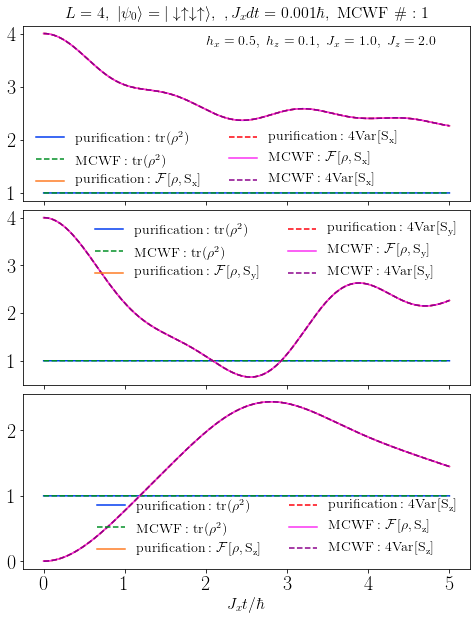

In [149]:
# plot
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8,10))
plt.subplots_adjust(hspace=0.05)

# Sx
ax[0].plot(pure['Time'], np.real(pure['Purity']), label=r'$\rm{purification:} ~ \rm{tr}(\rho^{2})$')
ax[0].plot(mcwf['Time'], np.real(mcwf['Purity'][0,:]), '--', label=r'$\rm{MCWF:} ~ \rm{tr}(\rho^{2})$')

ax[0].plot(pure['Time'], np.real(pure['QFI_Sx']), label=r'$\rm{purification:} ~\mathcal{F}[\rho,S_{x}]$')
ax[0].plot(pure['Time'], 4*np.real(pure['Var(Sx)']), '--', label=r'$\rm{purification:} ~4\rm{Var}[S_{x}]$')


ax[0].plot(mcwf['Time'], np.real(mcwf['QFI_Sx'][0,:]), label=r'$\rm{MCWF:} ~\mathcal{F}[\rho,S_{x}]$')
ax[0].plot(mcwf['Time'], 4*np.real(mcwf['Var(Sx)'][0,:]), '--', label=r'$\rm{MCWF:} ~4\rm{Var}[S_{x}]$')

# Sy
ax[1].plot(pure['Time'], np.real(pure['Purity']), label=r'$\rm{purification:} ~ \rm{tr}(\rho^{2})$')
ax[1].plot(mcwf['Time'], np.real(mcwf['Purity'][0,:]), '--', label=r'$\rm{MCWF:} ~ \rm{tr}(\rho^{2})$')

ax[1].plot(pure['Time'], np.real(pure['QFI_Sy']), label=r'$\rm{purification:} ~\mathcal{F}[\rho,S_{y}]$')
ax[1].plot(pure['Time'], 4*np.real(pure['Var(Sy)']), '--', label=r'$\rm{purification:} ~4\rm{Var}[S_{y}]$')

ax[1].plot(mcwf['Time'], np.real(mcwf['QFI_Sy'][0,:]), label=r'$\rm{MCWF:} ~ \mathcal{F}[\rho,S_{y}]$')
ax[1].plot(mcwf['Time'], 4*np.real(mcwf['Var(Sy)'][0,:]), '--', label=r'$\rm{MCWF:} ~4\rm{Var}[S_{y}]$')

# Sz
ax[2].plot(pure['Time'], np.real(pure['Purity']), label=r'$\rm{purification:} ~ \rm{tr}(\rho^{2})$')
ax[2].plot(mcwf['Time'], np.real(mcwf['Purity'][0,:]), '--', label=r'$\rm{MCWF:} ~ \rm{tr}(\rho^{2})$')

ax[2].plot(pure['Time'], np.real(pure['QFI_Sz']), label=r'$\rm{purification:} ~ \mathcal{F}[\rho,S_{z}]$')
ax[2].plot(pure['Time'], 4*np.real(pure['Var(Sz)']), '--', label=r'$\rm{purification:} ~4\rm{Var}[S_{z}]$')

ax[2].plot(mcwf['Time'], np.real(mcwf['QFI_Sz'][0,:]), label=r'$\rm{MCWF:} ~ \mathcal{F}[\rho,S_{z}]$')
ax[2].plot(mcwf['Time'], 4*np.real(mcwf['Var(Sz)'][0,:]), '--', label=r'$\rm{MCWF:} ~4\rm{Var}[S_{z}]$')

ax[2].set_xlabel(r'$J_{x}t/\hbar$', fontsize=16);
ax[0].legend(loc=3, ncol=2, fontsize=14);
ax[1].legend(loc=1, ncol=2, fontsize=14);
ax[2].legend(loc=4, ncol=2, fontsize=14);
ax[0].set_title(r'$L = %i,~ |\psi_{0}\rangle = |\downarrow\uparrow\downarrow\uparrow\rangle, ~$' % (p['N']) + \
                r'$, J_{x}dt = %.3f\hbar, ~ \rm{MCWF} ~ \#: %i$'% (p['dt'], p['MCSamples']), fontsize=16);
ax[0].text(2.0, 3.75, r'$h_{x}=%.1f,~h_{z}=%.1f,~J_{x}=%.1f,~J_{z}=%.1f$' % \
           (p['hx'],p['hz'],p['Jx'],p['Jz']), fontsize=14);
plt.savefig('Test3_QFI_Variance_Equivalence_PurestateNoDissipation.pdf')

### Test 4: QFI for GS of Heisenberg chain is maximal

In [150]:
# NOTE:
# The GS of the isotropic Heisenberg XXX chain is 2(Ns) + 1 fold degenerate 
# To see this, the maximally polarised state |111111...> as well as the time-reversed |0000.....> are both 
# GS of H. They both belong to the |Ns,Ns> manifold i.e. - here for s = 1/2 - the |N/2,N/2>. We can build 
# the global ladder operators S-|Ns,Ns> ~ |Ns, Ns-1> and iteratively applying it, we build the 2(Ns)+1 states
# |Ns,Ns>, |Ns,Ns-1>, ...., |Ns,-(Ns-1)>, |Ns, -Ns> of the S = Ns manifold. It is 2S+1 fold degenerate and
# since [H,Sx]=[H,Sy]=[H,Sz]=[H,S^2]=0 the model has the full SU(2) rotation symmetry thus all 2(Ns)+1 states 
# have the same energy. Hence when setting Jx = Jz (isotropic) point we will, everytime we try to find the GS
# a new superposition as a possible, valid, GS which gives a different QFI. Thus here we tune slightly away
# from the isotropic point Jz = (1 - 1e-8)Jz, effectively realising a very weak XXZ chain which lifts the GS 
# degeneracy. We thus get a unique GS and a unique QFI which asymptotically (as a function of the anisotropy)
# flows towards the maximal upper bound of the QFI for the GS of the isotropic Heisenberg chain.

In [151]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 10 # system size
p['Symmetry'] = None # which Sz quantum number sector (full Hilbert space = None)
p['hx'] = 0.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 1 - 1e-8 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.0 # time step
p['t_final'] = 0.0
p['verbose'] = True

# Monte-Carlo samples
p['MCSamples'] = 1

In [152]:
# build Hamiltonian
state_table = generate_state_table(p)
H = make_Hamiltonian(p, state_table)

# compute GS
E0, GS = LA.eigsh(H, k=1, which='SA')

# build generator
for i in range(p['N']):
    if i == 0:
        Sx = Sx_matrix(p, i, state_table)
        Sz = Sz_matrix(p, i, state_table)
    else:
        Sx += Sx_matrix(p, i, state_table)
        Sz += Sz_matrix(p, i, state_table)

# compute QFI for the generator
QFI = quantum_fisher_info(build_densitymatrix(GS), Sx, p['tol'])[0]

# compute variance of generator
Var = (expct_val(Sx.dot(Sx), GS)[0][0] - expct_val(Sx, GS)**2)[0][0]

# GS upper bound
QFI_max = 4 * (p['N']/2) * (p['N']/2 + 1) / 2

print(len(state_table), E0, QFI/(p['N']**2), 4*np.real(Var)/(p['N']**2), QFI_max/(p['N']**2))

1024 [-2.25] 0.5999987881072788 0.5999987881072772 0.6


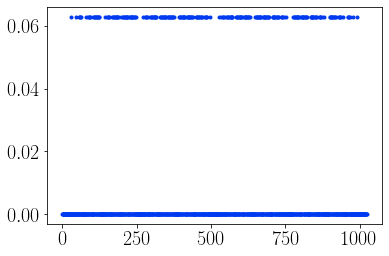

In [153]:
plt.plot(np.abs(GS), '.')

### Test 5: QFI for GS of Heisenberg chain is maximal (check different GS configurations)

In [159]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 4 # system size
p['Symmetry'] = None # which Sz quantum number sector (full Hilbert space = None)
p['hx'] = 0.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 1.0 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.0 # time step
p['t_final'] = 0.0
p['verbose'] = True

# Monte-Carlo samples
p['MCSamples'] = 1

In [160]:
# build Hamiltonian
state_table = generate_state_table(p)
H = make_Hamiltonian(p, state_table)

# compute GS
E0, GS = LA.eigsh(H, k=1, which='SA')

# build generator
for i in range(p['N']):
    if i == 0:
        Sx = Sx_matrix(p, i, state_table)
        Sz = Sz_matrix(p, i, state_table)
    else:
        Sx += Sx_matrix(p, i, state_table)
        Sz += Sz_matrix(p, i, state_table)

# compute QFI for the generator
QFI = quantum_fisher_info(build_densitymatrix(GS), Sx, p['tol'])[0]

# compute variance of generator
Var = (expct_val(Sx.dot(Sx), GS)[0][0] - expct_val(Sx, GS)**2)[0][0]

# GS upper bound
QFI_max = 4 * (p['N']/2) * (p['N']/2 + 1) / 2

print("dim(H)=%i \t E0 = %.2f \t QFI/(N^2)=%.6f \t 4*Var/(N^2)=%.6f \t max(QFI)/(N^2)=%.6f" % \
      (len(state_table), E0, QFI/(p['N']**2), 4*np.real(Var)/(p['N']**2), QFI_max/(p['N']**2)))

dim(H)=16 	 E0 = -0.75 	 QFI/(N^2)=0.502822 	 4*Var/(N^2)=0.502822 	 max(QFI)/(N^2)=0.750000


0 [0, 0, 0, 0]
1 [0, 0, 0, 1]
2 [0, 0, 1, 0]
3 [0, 0, 1, 1]
4 [0, 1, 0, 0]
5 [0, 1, 0, 1]
6 [0, 1, 1, 0]
7 [0, 1, 1, 1]
8 [1, 0, 0, 0]
9 [1, 0, 0, 1]
10 [1, 0, 1, 0]
11 [1, 0, 1, 1]
12 [1, 1, 0, 0]
13 [1, 1, 0, 1]
14 [1, 1, 1, 0]
15 [1, 1, 1, 1]


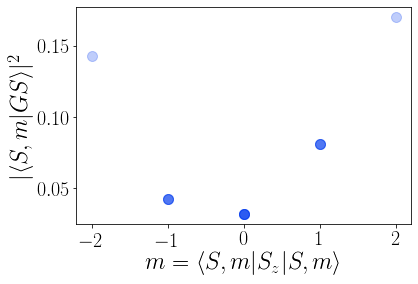

In [161]:
Stotal = np.zeros(np.shape(GS), dtype=float)
for i,s in enumerate(state_table):
    Stotal[i] = np.sum(np.asarray(int_to_state(p,s)) - 0.5)
    print(i, int_to_state(p,s))

# rgba_colors = np.zeros((len(Stotal),4))
# # for blue the third column needs to be one
# rgba_colors[:,2] = 1.0
# # the fourth column needs to be your alphas
# rgba_colors[:, 3] = np.abs(GS.flatten())**2
# plt.scatter(Stotal, np.abs(GS)**2, s=50, marker='o', color=rgba_colors)
plt.plot(Stotal, np.abs(GS)**2, 'o', alpha=0.25, markersize=10)
plt.xlabel(r'$m = \langle S,m|S_{z}|S,m\rangle$');
plt.ylabel(r'$|\langle S,m|GS\rangle|^{2}$');

In [162]:
# Build different GS
GSs = np.zeros((np.size(GS), p['N']+1), dtype=complex)

# build all basis states of |S,m> manifold, where S = N/2
S = p['N']/2
for i, m in enumerate(np.arange(start=S, stop=-(S+1), step=-1)):
    counter = 0
    for s in state_table:
        if np.sum(np.asarray(int_to_state(p,s)) - 0.5) == m:
            GSs[state_table.index(s),i] = 1.0
            counter += 1
    GSs[:,i] /= np.sqrt(counter)

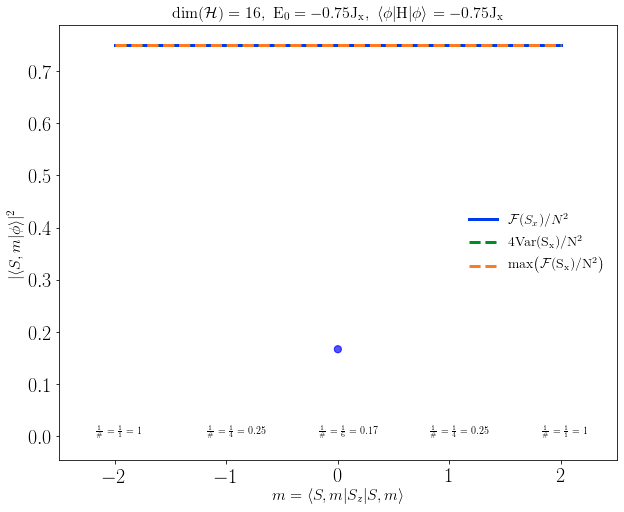

In [163]:
inds = np.array([2])
for i in range(len(inds)):
    if i == 0:
        phi = GSs[:,inds[i]] / np.sqrt(len(inds))
    else:
        phi += GSs[:,inds[i]] / np.sqrt(len(inds))
    
# compute energy
Energy = np.real(expct_val(H.toarray(), phi)) if np.imag(expct_val(H.toarray(), phi)) < p['tol'] else Nan
# compute QFI for the generator
QFI = quantum_fisher_info(build_densitymatrix(phi), Sx, p['tol'])[0]

# compute variance of generator
Var = (expct_val(Sx.dot(Sx), phi) - expct_val(Sx, phi)**2)

# GS upper bound
QFI_max = 4 * (p['N']/2) * (p['N']/2 + 1) / 2


plt.figure(figsize=(10,8))
rgba_colors = np.zeros((len(Stotal),4))
# for blue the third column needs to be one
rgba_colors[:,2] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = np.abs(phi.flatten())**2

# plot GS manifold basis state weights
# plt.plot(Stotal, np.abs(phi)**2, 'o', alpha=0.25, markersize=10)
plt.scatter(Stotal, np.abs(phi)**2, s=50, marker='o', color=rgba_colors)

# plot QFI(Sx)
plt.plot(np.array([-S, S]), QFI/(p['N']**2) * np.array([1, 1]), '-', linewidth=3, \
         label=r'$\mathcal{F}(S_{x})/N^{2}$')
# plot 4*Var(Sx)
plt.plot(np.array([-S, S]), 4*np.real(Var)/(p['N']**2) * np.array([1, 1]), '--', linewidth=3, \
         label=r'$4\rm{Var}(S_{x})/N^{2}$')
# plot max{QFI(Sx)}
plt.plot(np.array([-S, S]), QFI_max/(p['N']**2) * np.array([1, 1]), '--', linewidth=3, \
        label=r'$\rm{max}\Big(\mathcal{F}(S_{x})/N^{2}\Big)$')

# add multiplicity label
for i in range(p['N']+1):
    plt.text(p['N']/2 - i - 0.17, 0.0, r'$\frac{1}{\#} = \frac{1}{%i} = %.2g$' % \
             (scipy.special.binom(p['N'],i), 1/scipy.special.binom(p['N'],i)))
    
plt.xlabel(r'$m = \langle S,m|S_{z}|S,m\rangle$', fontsize=16);
plt.ylabel(r'$|\langle S,m|\phi\rangle|^{2}$', fontsize=16);
plt.title(r'$\rm{dim}(\mathcal{H})=%i, ~ E_{0} = %.2fJ_{x}, ~ \langle\phi|H|\phi\rangle = %.2fJ_{x}$' % \
          (len(state_table), E0, Energy), fontsize=16);
plt.legend(fontsize=14);
plt.xlim([-p['N']/2 - 0.5, p['N']/2 + 0.5]);

### Feel out realistic system sizes and evolution times

In [5]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 2 # system size
p['Symmetry'] = None # full Hilbert space
p['hx'] = 0.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = 1.0 # (global) spin-flip coupling
p['Jz'] = 0.6 # (global) nearest neighbour spin-spin interaction
p['tol'] = 1e-20 # tolerance in QFI calculation on eigenvalues

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.4
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 0.4

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.01 # time step
p['t_final'] = 5.0
p['verbose'] = True

# Monte-Carlo samples
p['MCSamples'] = 1000

# initial state
# classical AFM state as initial state
# p['psi0'] = [np.mod(i,2) for i in range(p['N'])]
# classical FM state as initial state
# p['psi0'] = [1 for i in range(p['N'])] 
# # some superposition
state_table = generate_state_table(p)
p['psi0'] = np.zeros(shape=(len(state_table),1), dtype=complex)
p['psi0'][state_table.index(state_table[-1])] = 1/np.sqrt(2)
p['psi0'][state_table.index(state_table[-2])] = 1/np.sqrt(2)

#### Purification

In [73]:
# Purification Evolution
tic = time.time()
state_table = generate_state_table(p)
pure, state_table = evolve_purification(p, state_table, build_densitymatrix(p['psi0']), kind="matrix", \
                                        verbose=p['verbose'])
toc = time.time()
print("Purification evolution took ", toc-tic, "s")

t = 0.500/5.000 	 10.0 	 0s

t = 1.000/5.000 	 20.0 	 1s

t = 1.500/5.000 	 29.9 	 1s

t = 2.000/5.000 	 39.9 	 1s

t = 2.500/5.000 	 49.9 	 1s

t = 3.000/5.000 	 59.9 	 1s

t = 3.500/5.000 	 69.9 	 1s

t = 4.000/5.000 	 79.8 	 2s

t = 4.500/5.000 	 89.8 	 2s

Purification evolution took  2.09624981880188 s


In [74]:
# add simulation parameters to the output dictionary
for key in p.keys():
    pure[key] = p[key]
pure['psi0'] = p['psi0']

# saving metadata
with open('data/XXZ_Pure_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f' % \
          (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
           p['dt'], p['t_initial'], p['t_final']) + '.pickle', 'wb') as fname:
    pickle.dump(pure, fname)

In [6]:
# get data
pure = {}
path = 'data/'
filename = 'XXZ_Pure_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f' % \
            (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
             p['dt'], p['t_initial'], p['t_final'])
with open(path + filename + '.pickle','rb') as file:
    pure = pickle.load(file, encoding='latin1')

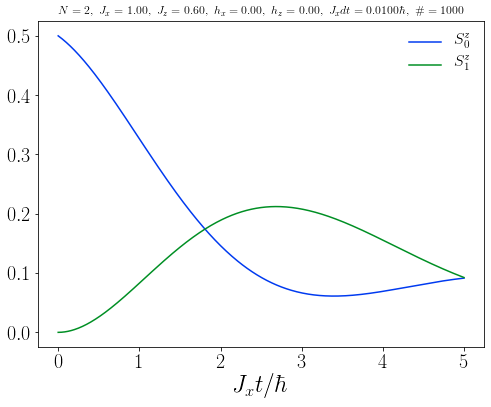

In [76]:
plt.figure(figsize=(8,6))
plt.plot(pure['Time'], np.real(pure['Sz(0)']), label=r'$S^{z}_{0}$')
plt.plot(pure['Time'], np.real(pure['Sz(1)']), label=r'$S^{z}_{1}$')
# plt.plot(pure['Time'], np.real(pure['Purity']))
# plt.plot(pure['Time'], 4 * np.real(pure['Var(Sz)']))
# plt.plot(pure['Time'], np.real(pure['QFI_Sz']))
# plt.plot(pure['Time'], np.real(pure['QFI_Sy']))
# plt.plot(pure['Time'], np.real(pure['QFI_Sz']))
plt.xlabel(r'$J_{x}t/\hbar$')
plt.legend()
plt.title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,~J_{x}dt=%.4f\hbar,~\#=%i$' % \
          (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['dt'],p['MCSamples']), fontsize=12);

#### Quantum Trajectories

In [77]:
# Quantum Trajectory Evolution
tic = time.time()
state_table = generate_state_table(p)
mcwf, state_table = MonteCarloScheduler(p, state_table, p['psi0'], kind="vector", verbose=p['verbose'])
toc = time.time()
print("MCWF evolution took ", toc-tic, "s")

t = 0.500/5.000 	 10.0 	 0s

t = 1.000/5.000 	 20.0 	 0s

t = 1.500/5.000 	 29.9 	 1s

t = 2.000/5.000 	 39.9 	 1s

t = 2.500/5.000 	 49.9 	 1s

t = 3.000/5.000 	 59.9 	 1s

t = 3.500/5.000 	 69.9 	 1s

t = 4.000/5.000 	 79.8 	 1s

t = 4.500/5.000 	 89.8 	 1s

#MCs = 100/1000 	 10.0 	 132s

t = 1.290, i=129, number of jumps = 2
#MCs = 200/1000 	 20.0 	 277s

t = 2.160, i=216, number of jumps = 2
#MCs = 300/1000 	 30.0 	 414s

#MCs = 400/1000 	 40.0 	 548s

#MCs = 500/1000 	 50.0 	 681s

#MCs = 600/1000 	 60.0 	 816s

#MCs = 700/1000 	 70.0 	 978s

#MCs = 800/1000 	 80.0 	 1139s

#MCs = 900/1000 	 90.0 	 1291s

MCWF evolution took  1458.4922938346863 s


In [8]:
# add simulation parameters to the output dictionary
for key in p.keys():
    mcwf[key] = p[key]
mcwf['psi0'] = p['psi0']

# saving metadata
with open('data/XXZ_MCWF_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f_#%i' % \
          (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
           p['dt'], p['t_initial'], p['t_final'], p['MCSamples']) + '.pickle', 'wb') as fname:
    pickle.dump(mcwf, fname)

In [9]:
# get data
mcwf = {}
path = 'data/'
filename = 'XXZ_MCWF_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f_#%i' % \
            (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
             p['dt'], p['t_initial'], p['t_final'], p['MCSamples'])
with open(path + filename + '.pickle','rb') as file:
    mcwf = pickle.load(file, encoding='latin1')

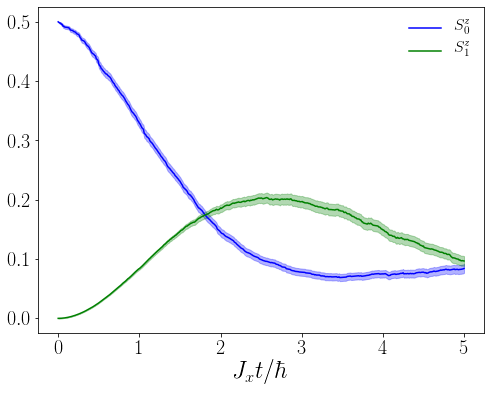

In [80]:
plt.figure(figsize=(8,6))
plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)_MCav']), 'b-', label=r'$S^{z}_{0}$')
plt.fill_between(mcwf['Time'], np.real(mcwf['Sz(0)_MCav']) - np.real(mcwf['Sz(0)_MCsd']), \
                 np.real(mcwf['Sz(0)_MCav']) + np.real(mcwf['Sz(0)_MCsd']), alpha=0.3, color='b')
plt.plot(mcwf['Time'], np.real(mcwf['Sz(1)_MCav']), 'g-', label=r'$S^{z}_{1}$')
plt.fill_between(mcwf['Time'], np.real(mcwf['Sz(1)_MCav']) - np.real(mcwf['Sz(1)_MCsd']), \
                 np.real(mcwf['Sz(1)_MCav']) + np.real(mcwf['Sz(1)_MCsd']), alpha=0.3, color='g')

# plt.plot(mcwf['Time'], np.real(mcwf['Sx_MCav']), '-', label=r'$S^{x}$')
# plt.fill_between(mcwf['Time'], np.real(mcwf['Sx_MCav']) - np.real(mcwf['Sx_MCsd']), \
#                  np.real(mcwf['Sx_MCav']) + np.real(mcwf['Sx_MCsd']), alpha=0.3)

# plt.plot(mcwf['Time'], np.real(mcwf['Sy_MCav']), '-', label=r'$S^{y}$')
# plt.fill_between(mcwf['Time'], np.real(mcwf['Sy_MCav']) - np.real(mcwf['Sy_MCsd']), \
#                  np.real(mcwf['Sy_MCav']) + np.real(mcwf['Sy_MCsd']), alpha=0.3)

# plt.plot(mcwf['Time'], np.real(mcwf['Sz_MCav']), '-', label=r'$S^{z}$')
# plt.fill_between(mcwf['Time'], np.real(mcwf['Sz_MCav']) - np.real(mcwf['Sz_MCsd']), \
#                  np.real(mcwf['Sz_MCav']) + np.real(mcwf['Sz_MCsd']), alpha=0.3)

# plt.plot(mcwf['Time'], np.real(mcwf['SxSx_MCav']), '-', label=r'$S^{2}_{x}$')
# plt.fill_between(mcwf['Time'], np.real(mcwf['SxSx_MCav']) - np.real(mcwf['SxSx_MCsd']), \
#                  np.real(mcwf['SxSx_MCav']) + np.real(mcwf['SxSx_MCsd']), alpha=0.3)

# plt.plot(mcwf['Time'], np.real(mcwf['SySy_MCav']), '-', label=r'$S^{2}_{y}$')
# plt.fill_between(mcwf['Time'], np.real(mcwf['SySy_MCav']) - np.real(mcwf['SySy_MCsd']), \
#                  np.real(mcwf['SySy_MCav']) + np.real(mcwf['SySy_MCsd']), alpha=0.3)

# plt.plot(mcwf['Time'], np.real(mcwf['SzSz_MCav']), '-', label=r'$S^{2}_{z}$')
# plt.fill_between(mcwf['Time'], np.real(mcwf['SzSz_MCav']) - np.real(mcwf['SzSz_MCsd']), \
#                  np.real(mcwf['SzSz_MCav']) + np.real(mcwf['SzSz_MCsd']), alpha=0.3)

# plt.plot(mcwf['Time'], np.real(mcwf['SxSx_MCav'] + mcwf['SySy_MCav'] + mcwf['SzSz_MCav']), '-', \
#          label=r'$S^{2}$')

plt.xlabel(r'$J_{x}t/\hbar$')
plt.legend()
# plt.title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,~J_{x}dt=%.4f\hbar,~\#=%i$' % \
#           (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['dt'],p['MCSamples']), fontsize=12);

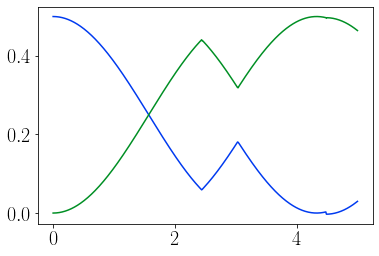

In [107]:
# plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)'][0,:]))
# plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)'][1,:]))
# plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)'][2,:]))
i = 900
plt.plot(mcwf['Time'], np.real(mcwf['Sz(0)'][i,:]), '-')
plt.plot(mcwf['Time'], np.real(mcwf['Sz(1)'][i,:]), '-')
# plt.plot(mcwf['Time'], np.real(mcwf['Sz'][i,:]))

In [338]:
# # purification
# plt.plot(pure['Time'], np.real(pure['QFI_Sy']))
# plt.plot(pure['Time'], 4*np.real(pure['Var(Sy)']), '-')

# # mcwf
# plt.plot(mcwf['Time'], np.real(mcwf['QFI_Sy_MCav']))
# plt.plot(mcwf['Time'], 4*np.real(mcwf['Var(Sy)_MCav']), '-')

# # purification
# plt.plot(pure['Time'], np.real(pure['Sy']))
# plt.plot(mcwf['Time'], np.real(mcwf['Sy_MCav']), '-')

#### QuTiP

In [10]:
def integrate(p, psi0, solver, return_states):

    si = qeye(2)
    sx = 0.5 * sigmax()
    sy = 0.5 * sigmay()
    sz = 0.5 * sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(p['N']):
        op_list = []
        for m in range(p['N']):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(p['N']):
        H += - p['hx'] * sx_list[n] # - hx[n] * sx_list[n]
        H += - p['hz'] * sz_list[n] # - hz[n] * sz_list[n]

    # interaction terms
    for n in range(p['N']-1):
        H += - p['Jx'] * sx_list[n] * sx_list[n+1] # - Jx[n] * sx_list[n] * sx_list[n+1]
        H += - p['Jx'] * sy_list[n] * sy_list[n+1] # - Jy[n] * sy_list[n] * sy_list[n+1]
        H += - p['Jz'] * sz_list[n] * sz_list[n+1] # - Jz[n] * sz_list[n] * sz_list[n+1]

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(p['N']):
        if p['gamma_Sz'] != 0.0: # gamma_Sz[n] > 0.0:
            c_op_list.append(np.sqrt(p['gamma_Sz']) * sz_list[n])
            
    # spin flip
    for n in range(p['N']):
        if p['gamma_Sx'] != 0.0: # gamma_Sx[n] > 0.0:
            c_op_list.append(np.sqrt(p['gamma_Sx']) * sx_list[n])
            
    # measurement operators
    e_list = []
    print("Measurement operators:\n")
    index = 0
    for n in range(p['N']):
        e_list.append(sx_list[n])
        print("#%i Sx(%i)" % (index, n))
        # print(sx_list[n])
        index += 1
        
        e_list.append(sy_list[n])
        print("#%i Sy(%i)" % (index, n))
        # print(sy_list[n])
        index += 1
        
        e_list.append(sz_list[n])
        print("#%i Sz(%i)" % (index, n))
        # print(sz_list[n])
        index += 1
        
        
        # total operators
        if n == 0:
            Sx = sx_list[n]
            Sy = sy_list[n]
            Sz = sz_list[n]
        else:
            Sx += sx_list[n]
            Sy += sy_list[n]
            Sz += sz_list[n]
    
    e_list.append(Sx)
    print("#%i Sx" % (index))
    # print(Sx)
    index += 1
    
    e_list.append(Sx*Sx)
    print("#%i SxSx" % (index))
    # print(Sx*Sx)
    index += 1
    
    e_list.append(Sy)
    print("#%i Sy" % (index))
    # print(Sy)
    index += 1
    
    e_list.append(Sy*Sy)
    print("#%i SySy" % (index))
    # print(Sy*Sy)
    index += 1
    
    e_list.append(Sz)
    print("#%i Sz" % (index))
    # print(Sz)
    index += 1
    
    e_list.append(Sz*Sz)
    print("#%i SzSz" % (index))
    # print(Sz*Sz)
    index += 1
        
    # build time vector
    tlist = np.arange(start=p['t_initial'], stop=(p['t_final'] + p['dt']), step=p['dt'])

    # evolve and calculate expectation values
    if solver == "me":
        result = mesolve(H=H, rho0=psi0, tlist=tlist, c_ops=c_op_list, e_ops=e_list, \
                         progress_bar=True, options=Options(store_states=return_states))
    elif solver == "mc":
        ntraj = p['MCSamples'] # 250
        result = mcsolve(H=H, psi0=psi0, tlist=tlist, c_ops=c_op_list, e_ops=e_list, ntraj=ntraj, \
                         progress_bar=True, options=Options(store_states=return_states))

    return result.expect, result.states, e_list

In [11]:
p['psi0']

array([[0.        +0.j],
       [0.        +0.j],
       [0.70710678+0.j],
       [0.70710678+0.j]])

In [12]:
# note for QuTiP 0 = up and 1 = down
(tensor([basis(2,0), basis(2,0)]) + tensor([basis(2,0), basis(2,1)])) / np.sqrt(2)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]]

##### Purification

In [13]:
# set up the calculation

solver = "me"   # use the ode solver
# solver = "mc"   # use the monte-carlo solver

# return states?
return_states = True

# intial state, first spin in state |1>, the rest in state |1>
# psi_list = []
# psi_list.append(basis(2,0))
# for n in range(p['N'] - 1):
#     psi_list.append(basis(2,0))
# psi0 = tensor(psi_list)
psi0 = (tensor([basis(2,0), basis(2,0)]) + tensor([basis(2,0), basis(2,1)])) / np.sqrt(2)

expct, states, e_list = integrate(p, psi0, solver, return_states=return_states)

Measurement operators:

#0 Sx(0)
#1 Sy(0)
#2 Sz(0)
#3 Sx(1)
#4 Sy(1)
#5 Sz(1)
#6 Sx
#7 SxSx
#8 Sy
#9 SySy
#10 Sz
#11 SzSz
10.2%. Run time:   0.04s. Est. time left: 00:00:00:00
20.2%. Run time:   0.05s. Est. time left: 00:00:00:00
30.1%. Run time:   0.06s. Est. time left: 00:00:00:00
40.1%. Run time:   0.08s. Est. time left: 00:00:00:00
50.1%. Run time:   0.09s. Est. time left: 00:00:00:00
60.1%. Run time:   0.12s. Est. time left: 00:00:00:00
70.1%. Run time:   0.15s. Est. time left: 00:00:00:00
80.0%. Run time:   0.17s. Est. time left: 00:00:00:00
90.0%. Run time:   0.18s. Est. time left: 00:00:00:00
Total run time:   0.20s


In [14]:
Sx0 = np.real(expct[0])
Sy0 = np.real(expct[1])
Sz0 = np.real(expct[2])

Sx1 = np.real(expct[3])
Sy1 = np.real(expct[4])
Sz1 = np.real(expct[5])

Sx = np.real(expct[6])
SxSx = np.real(expct[7])
Sy = np.real(expct[8])
SySy = np.real(expct[9])
Sz = np.real(expct[10])
SzSz = np.real(expct[11])

In [15]:
# re-check the output expectation values by computing the <states|Op|states>
M = {}
measurement_list = ['Sx0', 'Sy0', 'Sz0', 'Sx1', 'Sy1', 'Sz1', 'Sx', 'SxSx', 'Sy', 'SySy', 'Sz', 'SzSz', \
                   'QFI_Sx', 'QFI_Sy', 'QFI_Sz']

for i, m_op in enumerate(e_list):
    M[measurement_list[i]] = m_op
M['QFI_Sx'] = M['Sx']
M['QFI_Sy'] = M['Sy']
M['QFI_Sz'] = M['Sz']
    
qutip_pure = {}
for key in M.keys():
    print(key)
    if key[:3] == 'QFI':
        qutip_pure[key] = np.zeros(np.shape(Sx0))
        for i in range(len(Sx0)):
            qutip_pure[key][i] = QuTiP_quantum_fisher_info(states[i], M[key], tol=p['tol'])
    else:
        qutip_pure[key] = expect(M[key], states)
qutip_pure['Var(Sx)'] = expect(M['SxSx'], states) - expect(M['Sx'], states)**2
qutip_pure['Var(Sy)'] = expect(M['SySy'], states) - expect(M['Sy'], states)**2
qutip_pure['Var(Sz)'] = expect(M['SzSz'], states) - expect(M['Sz'], states)**2

Sx0
Sy0
Sz0
Sx1
Sy1
Sz1
Sx
SxSx
Sy
SySy
Sz
SzSz
QFI_Sx
QFI_Sy
QFI_Sz


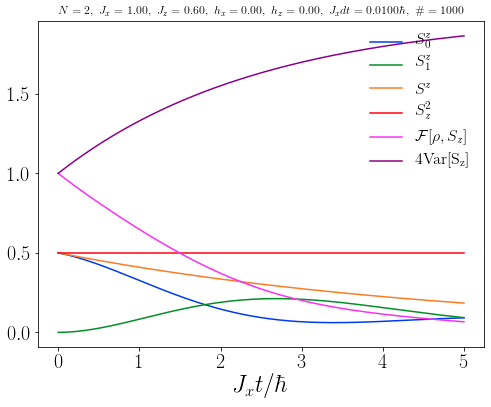

In [19]:
plt.figure(figsize=(8,6))

# Sx
# plt.plot(mcwf['Time'], qutip_pure['Sx0'], '-', label=r'$S^{x}_{0}$')
# plt.plot(mcwf['Time'], qutip_pure['Sx1'], '-', label=r'$S^{x}_{1}$')
# plt.plot(mcwf['Time'], qutip_pure['Sx'], '-', label=r'$S^{x}$')
# plt.plot(mcwf['Time'], qutip_pure['SxSx'], '-', label=r'$S^{2}_{x}$')
# plt.plot(mcwf['Time'], qutip_pure['QFI_Sx'], '-', label=r'$\mathcal{F}[\rho,S_{x}]$')
# plt.plot(mcwf['Time'], 4*qutip_pure['Var(Sx)'], '-', label=r'$4\rm{Var}[S_{x}]$')

# Sy
# plt.plot(mcwf['Time'], qutip_pure['Sy0'], '-', label=r'$S^{y}_{0}$')
# plt.plot(mcwf['Time'], qutip_pure['Sy1'], '-', label=r'$S^{y}_{1}$')
# plt.plot(mcwf['Time'], qutip_pure['Sy'], '-', label=r'$S^{y}$')
# plt.plot(mcwf['Time'], qutip_pure['SySy'], '-', label=r'$S^{2}_{y}$')
# plt.plot(mcwf['Time'], qutip_pure['QFI_Sy'], '-', label=r'$\mathcal{F}[\rho,S_{y}]$')
# plt.plot(mcwf['Time'], 4*qutip_pure['Var(Sy)'], '-', label=r'$4\rm{Var}[S_{y}]$')

# # Sz
plt.plot(mcwf['Time'], qutip_pure['Sz0'], '-', label=r'$S^{z}_{0}$')
plt.plot(mcwf['Time'], qutip_pure['Sz1'], '-', label=r'$S^{z}_{1}$')
plt.plot(mcwf['Time'], qutip_pure['Sz'], '-', label=r'$S^{z}$')
plt.plot(mcwf['Time'], qutip_pure['SzSz'], '-', label=r'$S^{2}_{z}$')
plt.plot(mcwf['Time'], qutip_pure['QFI_Sz'], '-', label=r'$\mathcal{F}[\rho,S_{z}]$')
plt.plot(mcwf['Time'], 4*qutip_pure['Var(Sz)'], '-', label=r'$4\rm{Var}[S_{z}]$')

plt.xlabel(r'$J_{x}t/\hbar$')
plt.legend()
plt.title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,~J_{x}dt=%.4f\hbar,~\#=%i$' % \
          (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['dt'],p['MCSamples']), fontsize=12);

##### Trajectories

In [20]:
# set up the calculation

# solver = "me"   # use the ode solver
solver = "mc"   # use the monte-carlo solver

# return states?
return_states = True

# intial state, first spin in state |1>, the rest in state |1>
# psi_list = []
# psi_list.append(basis(2,0))
# for n in range(p['N'] - 1):
#     psi_list.append(basis(2,0))
# psi0 = tensor(psi_list)
psi0 = (tensor([basis(2,0), basis(2,0)]) + tensor([basis(2,0), basis(2,1)])) / np.sqrt(2)

expct, states, e_list = integrate(p, psi0, solver, return_states=return_states)

Measurement operators:

#0 Sx(0)
#1 Sy(0)
#2 Sz(0)
#3 Sx(1)
#4 Sy(1)
#5 Sz(1)
#6 Sx
#7 SxSx
#8 Sy
#9 SySy
#10 Sz
#11 SzSz
10.0%. Run time:   3.53s. Est. time left: 00:00:00:31
20.0%. Run time:   6.72s. Est. time left: 00:00:00:26
30.0%. Run time:   9.85s. Est. time left: 00:00:00:22
40.0%. Run time:  13.40s. Est. time left: 00:00:00:20
50.0%. Run time:  16.75s. Est. time left: 00:00:00:16
60.0%. Run time:  20.09s. Est. time left: 00:00:00:13
70.0%. Run time:  23.56s. Est. time left: 00:00:00:10
80.0%. Run time:  26.96s. Est. time left: 00:00:00:06
90.0%. Run time:  30.40s. Est. time left: 00:00:00:03
100.0%. Run time:  34.46s. Est. time left: 00:00:00:00
Total run time:  34.53s


In [21]:
Sx0 = np.real(expct[0])
Sy0 = np.real(expct[1])
Sz0 = np.real(expct[2])

Sx1 = np.real(expct[3])
Sy1 = np.real(expct[4])
Sz1 = np.real(expct[5])

Sx = np.real(expct[6])
SxSx = np.real(expct[7])
Sy = np.real(expct[8])
SySy = np.real(expct[9])
Sz = np.real(expct[10])
SzSz = np.real(expct[11])

In [22]:
# re-check the output expectation values by computing the <states|Op|states>
M = {}
measurement_list = ['Sx0', 'Sy0', 'Sz0', 'Sx1', 'Sy1', 'Sz1', 'Sx', 'SxSx', 'Sy', 'SySy', 'Sz', 'SzSz']

for i, m_op in enumerate(e_list):
    M[measurement_list[i]] = m_op
# M['QFI_Sx'] = M['Sx']
# M['QFI_Sy'] = M['Sy']
# M['QFI_Sz'] = M['Sz']
    
qutip_mcwf = {}
for key in M.keys():
    print(key)
    qutip_mcwf[key + '_MCav'] = np.zeros(np.shape(Sx0))
    qutip_mcwf[key + '_MCsd'] = np.zeros(np.shape(Sx0))
    
    average = np.zeros(np.shape(Sx0))
    variance = np.zeros(np.shape(Sx0))
    for traj in range(np.shape(states)[0]):
        if key[:3] == 'QFI':
            for i in range(len(average)):
                expct_val = QuTiP_quantum_fisher_info(states[traj,i], M[key], tol=p['tol'])
                average[i] += expct_val / np.shape(states)[0]
                variance[i] += (expct_val**2) / np.shape(states)[0]
        else:
            expectation_value = np.real(expect(M[key], states[traj,:]))
            average += expectation_value / np.shape(states)[0]
            variance += (expectation_value**2) / np.shape(states)[0]
    
    qutip_mcwf[key + '_MCav'] = average
    qutip_mcwf[key + '_MCsd'] = np.sqrt((variance - average**2) / (np.shape(states)[0] - 1))

Sx0
Sy0


/Users/Johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


Sz0
Sx1
Sy1
Sz1
Sx
SxSx
Sy
SySy
Sz
SzSz


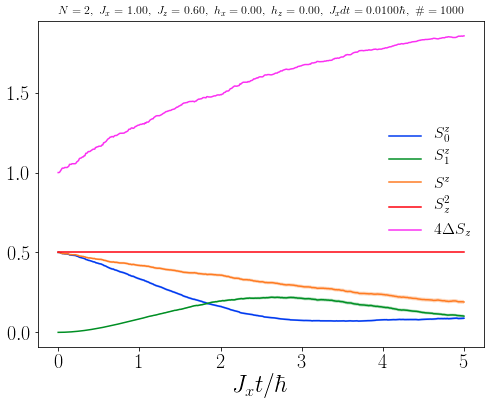

In [25]:
plt.figure(figsize=(8,6))

# Sx
# plt.plot(mcwf['Time'], qutip_mcwf['Sx0_MCav'], '-', label=r'$S^{x}_{0}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['Sx0_MCav'] - qutip_mcwf['Sx0_MCsd'], \
#                  qutip_mcwf['Sx0_MCav'] + qutip_mcwf['Sx0_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], qutip_mcwf['Sx1_MCav'], '-', label=r'$S^{x}_{1}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['Sx1_MCav'] - qutip_mcwf['Sx1_MCsd'], \
#                  qutip_mcwf['Sx1_MCav'] + qutip_mcwf['Sx1_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], qutip_mcwf['Sx_MCav'], '-', label=r'$S^{x}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['Sx_MCav'] - qutip_mcwf['Sx_MCsd'], \
#                  qutip_mcwf['Sx_MCav'] + qutip_mcwf['Sx_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], qutip_mcwf['SxSx_MCav'], '-', label=r'$S^{2}_{x}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['SxSx_MCav'] - qutip_mcwf['SxSx_MCsd'], \
#                  qutip_mcwf['SxSx_MCav'] + qutip_mcwf['SxSx_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], 4*(qutip_mcwf['SxSx_MCav'] - qutip_mcwf['Sx_MCav']**2), '-', \
#          label=r'$4 \Delta S_{x}$')

# # Sy
# plt.plot(mcwf['Time'], qutip_mcwf['Sy0_MCav'], '-', label=r'$S^{y}_{0}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['Sy0_MCav'] - qutip_mcwf['Sy0_MCsd'], \
#                  qutip_mcwf['Sy0_MCav'] + qutip_mcwf['Sy0_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], qutip_mcwf['Sy1_MCav'], '-', label=r'$S^{y}_{1}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['Sy1_MCav'] - qutip_mcwf['Sy1_MCsd'], \
#                  qutip_mcwf['Sy1_MCav'] + qutip_mcwf['Sy1_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], qutip_mcwf['Sy_MCav'], '-', label=r'$S^{y}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['Sy_MCav'] - qutip_mcwf['Sy_MCsd'], \
#                  qutip_mcwf['Sy_MCav'] + qutip_mcwf['Sy_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], qutip_mcwf['SySy_MCav'], '-', label=r'$S^{2}_{y}$')
# plt.fill_between(mcwf['Time'], qutip_mcwf['SySy_MCav'] - qutip_mcwf['SySy_MCsd'], \
#                  qutip_mcwf['SySy_MCav'] + qutip_mcwf['SySy_MCsd'], alpha=0.3)
# plt.plot(mcwf['Time'], 4*(qutip_mcwf['SySy_MCav'] - qutip_mcwf['Sy_MCav']**2), '-', \
#          label=r'$4 \Delta S_{y}$')


# Sz
plt.plot(mcwf['Time'], qutip_mcwf['Sz0_MCav'], '-', label=r'$S^{z}_{0}$')
plt.fill_between(mcwf['Time'], qutip_mcwf['Sz0_MCav'] - qutip_mcwf['Sz0_MCsd'], \
                 qutip_mcwf['Sz0_MCav'] + qutip_mcwf['Sz0_MCsd'], alpha=0.3)
plt.plot(mcwf['Time'], qutip_mcwf['Sz1_MCav'], '-', label=r'$S^{z}_{1}$')
plt.fill_between(mcwf['Time'], qutip_mcwf['Sz1_MCav'] - qutip_mcwf['Sz1_MCsd'], \
                 qutip_mcwf['Sz1_MCav'] + qutip_mcwf['Sz1_MCsd'], alpha=0.3)
plt.plot(mcwf['Time'], qutip_mcwf['Sz_MCav'], '-', label=r'$S^{z}$')
plt.fill_between(mcwf['Time'], qutip_mcwf['Sz_MCav'] - qutip_mcwf['Sz_MCsd'], \
                 qutip_mcwf['Sz_MCav'] + qutip_mcwf['Sz_MCsd'], alpha=0.3)
plt.plot(mcwf['Time'], qutip_mcwf['SzSz_MCav'], '-', label=r'$S^{2}_{z}$')
plt.fill_between(mcwf['Time'], qutip_mcwf['SzSz_MCav'] - qutip_mcwf['SzSz_MCsd'], \
                 qutip_mcwf['SzSz_MCav'] + qutip_mcwf['SzSz_MCsd'], alpha=0.3)
plt.plot(mcwf['Time'], 4*(qutip_mcwf['SzSz_MCav'] - qutip_mcwf['Sz_MCav']**2), '-', \
         label=r'$4 \Delta S_{z}$')

plt.xlabel(r'$J_{x}t/\hbar$')
plt.legend()
plt.title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,~J_{x}dt=%.4f\hbar,~\#=%i$' % \
          (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['dt'],p['MCSamples']), fontsize=12);

#### Comparison

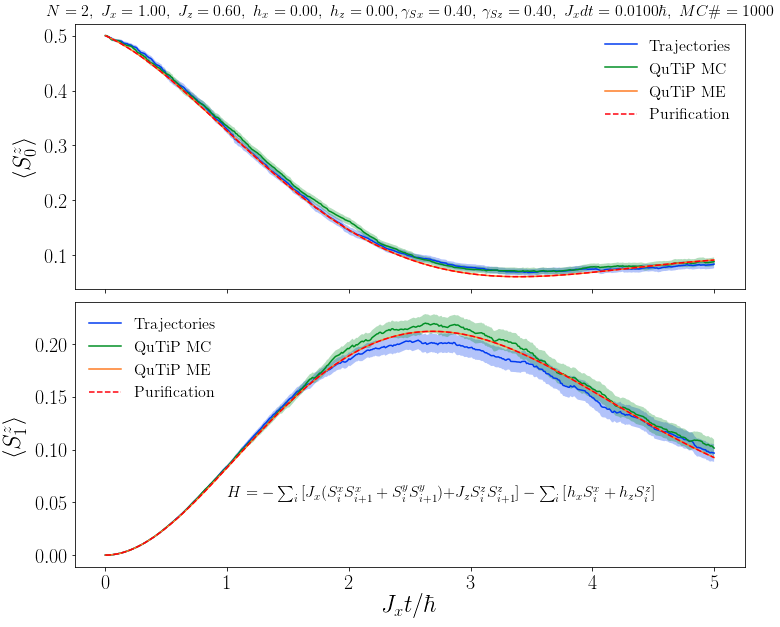

In [44]:
fig, ax = plt.subplots(2,1, figsize=(12,10), sharex=True)
plt.subplots_adjust(hspace=0.05)

# Sz(0)
ax[0].plot(mcwf['Time'], np.real(mcwf['Sz(0)_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[0].fill_between(mcwf['Time'], np.real(mcwf['Sz(0)_MCav']) - np.real(mcwf['Sz(0)_MCsd']), \
                 np.real(mcwf['Sz(0)_MCav']) + np.real(mcwf['Sz(0)_MCsd']), alpha=0.3)
ax[0].plot(mcwf['Time'], qutip_mcwf['Sz0_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[0].fill_between(mcwf['Time'], qutip_mcwf['Sz0_MCav'] - qutip_mcwf['Sz0_MCsd'], \
                   qutip_mcwf['Sz0_MCav'] + qutip_mcwf['Sz0_MCsd'], alpha=0.3)
ax[0].plot(mcwf['Time'], qutip_pure['Sz0'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[0].plot(pure['Time'], np.real(pure['Sz(0)']), '--', label=r'$\rm{Purification}$')
ax[0].legend()
ax[0].set_ylabel(r'$\langle S^{z}_{0} \rangle$')

# Sz(1)
ax[1].plot(mcwf['Time'], np.real(mcwf['Sz(1)_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[1].fill_between(mcwf['Time'], np.real(mcwf['Sz(1)_MCav']) - np.real(mcwf['Sz(1)_MCsd']), \
                 np.real(mcwf['Sz(1)_MCav']) + np.real(mcwf['Sz(1)_MCsd']), alpha=0.3)
ax[1].plot(mcwf['Time'], qutip_mcwf['Sz1_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[1].fill_between(mcwf['Time'], qutip_mcwf['Sz1_MCav'] - qutip_mcwf['Sz1_MCsd'], \
                   qutip_mcwf['Sz1_MCav'] + qutip_mcwf['Sz1_MCsd'], alpha=0.3)
ax[1].plot(mcwf['Time'], qutip_pure['Sz1'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[1].plot(pure['Time'], np.real(pure['Sz(1)']), '--', label=r'$\rm{Purification}$')
ax[1].legend()
ax[1].set_ylabel(r'$\langle S^{z}_{1} \rangle$')


ax[1].set_xlabel(r'$J_{x}t/\hbar$')
ax[1].text(1.0, 0.05, r'$H = -\sum_{i} \Big[ J_{x}(S_{i}^{x}S_{i+1}^{x} + S_{i}^{y}S_{i+1}^{y}) + $' + \
           r'$J_{z}S_{i}^{z}S_{i+1}^{z}\Big] - \sum_{i}\Big[ h_{x}S^{x}_{i} + h_{z}S^{z}_{i} \Big]$', \
          fontsize=16)
ax[0].set_title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,\gamma_{Sx}=%.2f,$' % \
                (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['gamma_Sx']) + \
                r'$~\gamma_{Sz}=%.2f,~J_{x}dt=%.4f\hbar,~ MC\#=%i$' % \
                (p['gamma_Sz'],p['dt'],p['MCSamples']), fontsize=16);

path = 'plots/'
filename = 'XXZ_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f_#%i' % \
            (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
             p['dt'], p['t_initial'], p['t_final'], p['MCSamples'])
# plt.savefig(path + filename + '_Sz.pdf')

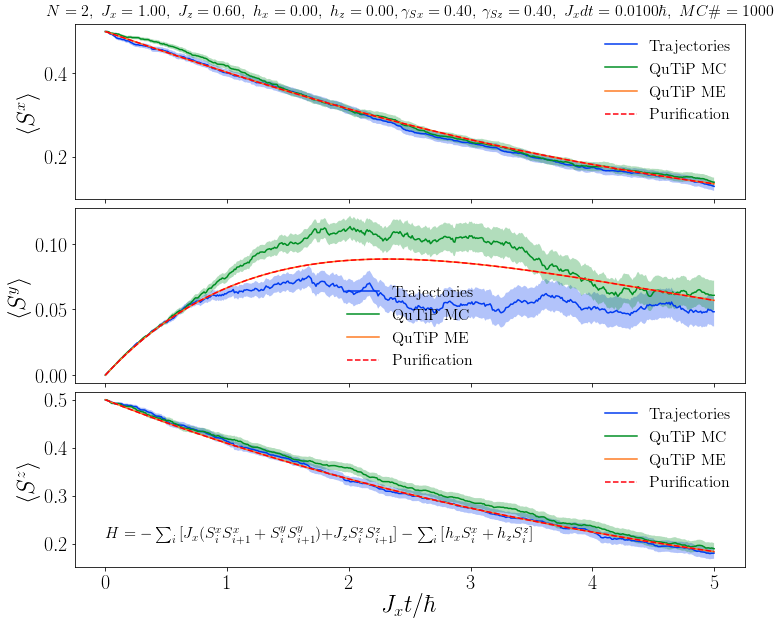

In [37]:
# Look at the Total Spin components
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True)
plt.subplots_adjust(hspace=0.05)

# Sx
ax[0].plot(mcwf['Time'], np.real(mcwf['Sx_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[0].fill_between(mcwf['Time'], np.real(mcwf['Sx_MCav']) - np.real(mcwf['Sx_MCsd']), \
                 np.real(mcwf['Sx_MCav']) + np.real(mcwf['Sx_MCsd']), alpha=0.3)
ax[0].plot(mcwf['Time'], qutip_mcwf['Sx_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[0].fill_between(mcwf['Time'], qutip_mcwf['Sx_MCav'] - qutip_mcwf['Sx_MCsd'], \
                   qutip_mcwf['Sx_MCav'] + qutip_mcwf['Sx_MCsd'], alpha=0.3)
ax[0].plot(mcwf['Time'], qutip_pure['Sx'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[0].plot(pure['Time'], np.real(pure['Sx']), '--', label=r'$\rm{Purification}$')
ax[0].legend()
ax[0].set_ylabel(r'$\langle S^{x} \rangle$')

# Sy
ax[1].plot(mcwf['Time'], np.real(mcwf['Sy_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[1].fill_between(mcwf['Time'], np.real(mcwf['Sy_MCav']) - np.real(mcwf['Sy_MCsd']), \
                 np.real(mcwf['Sy_MCav']) + np.real(mcwf['Sy_MCsd']), alpha=0.3)
ax[1].plot(mcwf['Time'], qutip_mcwf['Sy_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[1].fill_between(mcwf['Time'], qutip_mcwf['Sy_MCav'] - qutip_mcwf['Sy_MCsd'], \
                   qutip_mcwf['Sy_MCav'] + qutip_mcwf['Sy_MCsd'], alpha=0.3)
ax[1].plot(mcwf['Time'], qutip_pure['Sy'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[1].plot(pure['Time'], np.real(pure['Sy']), '--', label=r'$\rm{Purification}$')
ax[1].legend()
ax[1].set_ylabel(r'$\langle S^{y} \rangle$')

# Sz
ax[2].plot(mcwf['Time'], np.real(mcwf['Sz_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[2].fill_between(mcwf['Time'], np.real(mcwf['Sz_MCav']) - np.real(mcwf['Sz_MCsd']), \
                 np.real(mcwf['Sz_MCav']) + np.real(mcwf['Sz_MCsd']), alpha=0.3)
ax[2].plot(mcwf['Time'], qutip_mcwf['Sz_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[2].fill_between(mcwf['Time'], qutip_mcwf['Sz_MCav'] - qutip_mcwf['Sz_MCsd'], \
                   qutip_mcwf['Sz_MCav'] + qutip_mcwf['Sz_MCsd'], alpha=0.3)
ax[2].plot(mcwf['Time'], qutip_pure['Sz'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[2].plot(pure['Time'], np.real(pure['Sz']), '--', label=r'$\rm{Purification}$')
ax[2].legend()
ax[2].set_ylabel(r'$\langle S^{z} \rangle$')

ax[2].set_xlabel(r'$J_{x}t/\hbar$')
ax[2].text(0.0, 0.2, r'$H = -\sum_{i} \Big[ J_{x}(S_{i}^{x}S_{i+1}^{x} + S_{i}^{y}S_{i+1}^{y}) + $' + \
           r'$J_{z}S_{i}^{z}S_{i+1}^{z}\Big] - \sum_{i}\Big[ h_{x}S^{x}_{i} + h_{z}S^{z}_{i} \Big]$', \
          fontsize=16)
ax[0].set_title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,\gamma_{Sx}=%.2f,$' % \
                (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['gamma_Sx']) + \
                r'$~\gamma_{Sz}=%.2f,~J_{x}dt=%.4f\hbar,~ MC\#=%i$' % \
                (p['gamma_Sz'],p['dt'],p['MCSamples']), fontsize=16);

path = 'plots/'
filename = 'XXZ_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f_#%i' % \
            (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
             p['dt'], p['t_initial'], p['t_final'], p['MCSamples'])
# plt.savefig(path + filename + '_Sz.pdf')

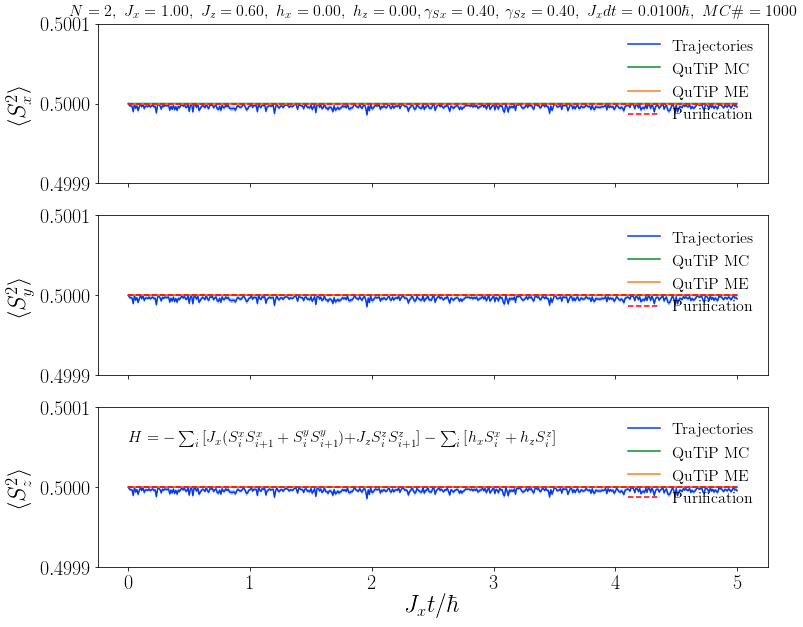

In [36]:
# Look at the Total Spin components
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True)
# plt.subplots_adjust(hspace=0.05)

# SxSx
ax[0].plot(mcwf['Time'], np.real(mcwf['SxSx_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[0].fill_between(mcwf['Time'], np.real(mcwf['SxSx_MCav']) - np.real(mcwf['SxSx_MCsd']), \
                 np.real(mcwf['SxSx_MCav']) + np.real(mcwf['SxSx_MCsd']), alpha=0.3)
ax[0].plot(mcwf['Time'], qutip_mcwf['SxSx_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[0].fill_between(mcwf['Time'], qutip_mcwf['SxSx_MCav'] - qutip_mcwf['SxSx_MCsd'], \
                   qutip_mcwf['SxSx_MCav'] + qutip_mcwf['SxSx_MCsd'], alpha=0.3)
ax[0].plot(mcwf['Time'], qutip_pure['SxSx'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[0].plot(pure['Time'], np.real(pure['SxSx']), '--', label=r'$\rm{Purification}$')
ax[0].legend()
ax[0].set_ylabel(r'$\langle S^{2}_{x} \rangle$')
ax[0].set_ylim([0.4999,0.5001])

# SySy
ax[1].plot(mcwf['Time'], np.real(mcwf['SySy_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[1].fill_between(mcwf['Time'], np.real(mcwf['SySy_MCav']) - np.real(mcwf['SySy_MCsd']), \
                 np.real(mcwf['SySy_MCav']) + np.real(mcwf['SySy_MCsd']), alpha=0.3)
ax[1].plot(mcwf['Time'], qutip_mcwf['SySy_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[1].fill_between(mcwf['Time'], qutip_mcwf['SySy_MCav'] - qutip_mcwf['SySy_MCsd'], \
                   qutip_mcwf['SySy_MCav'] + qutip_mcwf['SySy_MCsd'], alpha=0.3)
ax[1].plot(mcwf['Time'], qutip_pure['SySy'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[1].plot(pure['Time'], np.real(pure['SySy']), '--', label=r'$\rm{Purification}$')
ax[1].legend()
ax[1].set_ylabel(r'$\langle S^{2}_{y} \rangle$')
ax[1].set_ylim([0.4999,0.5001])

# SzSz
ax[2].plot(mcwf['Time'], np.real(mcwf['SzSz_MCav']), '-', label=r'$\rm{Trajectories}$')
ax[2].fill_between(mcwf['Time'], np.real(mcwf['SzSz_MCav']) - np.real(mcwf['SzSz_MCsd']), \
                 np.real(mcwf['SzSz_MCav']) + np.real(mcwf['SzSz_MCsd']), alpha=0.3)
ax[2].plot(mcwf['Time'], qutip_mcwf['SzSz_MCav'],  '-', label=r'$\rm{QuTiP ~ MC}$')
ax[2].fill_between(mcwf['Time'], qutip_mcwf['SzSz_MCav'] - qutip_mcwf['SzSz_MCsd'], \
                   qutip_mcwf['SzSz_MCav'] + qutip_mcwf['SzSz_MCsd'], alpha=0.3)
ax[2].plot(mcwf['Time'], qutip_pure['SzSz'],  '-', label=r'$\rm{QuTiP ~ ME}$')
ax[2].plot(pure['Time'], np.real(pure['SzSz']), '--', label=r'$\rm{Purification}$')
ax[2].legend()
ax[2].set_ylabel(r'$\langle S^{2}_{z} \rangle$')
ax[2].set_ylim([0.4999,0.5001])

ax[2].set_xlabel(r'$J_{x}t/\hbar$')
ax[2].text(0.0, 0.50005, r'$H = -\sum_{i} \Big[ J_{x}(S_{i}^{x}S_{i+1}^{x} + S_{i}^{y}S_{i+1}^{y}) + $' + \
           r'$J_{z}S_{i}^{z}S_{i+1}^{z}\Big] - \sum_{i}\Big[ h_{x}S^{x}_{i} + h_{z}S^{z}_{i} \Big]$', \
          fontsize=16)
ax[0].set_title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,\gamma_{Sx}=%.2f,$' % \
                (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['gamma_Sx']) + \
                r'$~\gamma_{Sz}=%.2f,~J_{x}dt=%.4f\hbar,~ MC\#=%i$' % \
                (p['gamma_Sz'],p['dt'],p['MCSamples']), fontsize=16);

path = 'plots/'
filename = 'XXZ_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f_#%i' % \
            (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
             p['dt'], p['t_initial'], p['t_final'], p['MCSamples'])
# plt.savefig(path + filename + '_Sz.pdf')

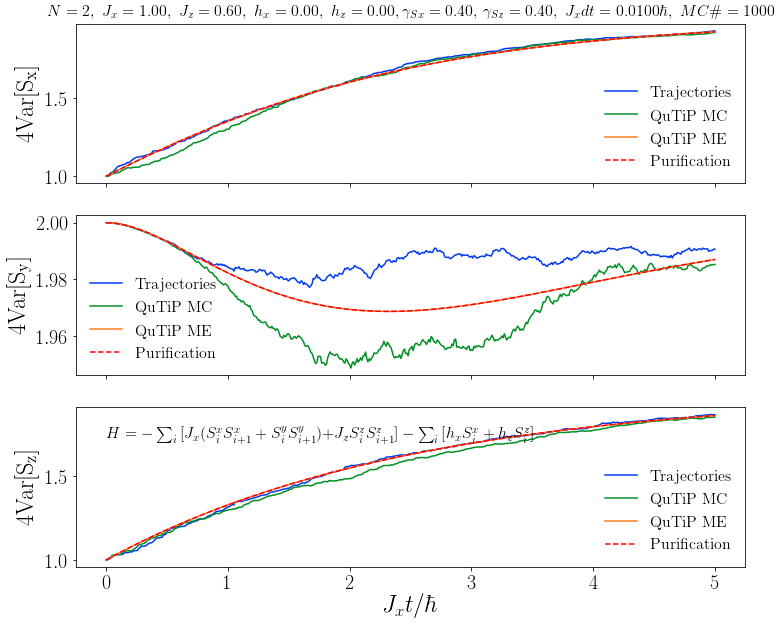

In [46]:
# Look at the Variance of the total Spin
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True)
# plt.subplots_adjust(hspace=0.05)

# 4*Var(Sx) = 4* (<SxSx> - <Sx>^2)
ax[0].plot(mcwf['Time'], 4 * np.real(mcwf['SxSx_MCav'] - mcwf['Sx_MCav']**2), '-', \
           label=r'$\rm{Trajectories}$')
ax[0].plot(mcwf['Time'], 4 * (qutip_mcwf['SxSx_MCav'] - qutip_mcwf['Sx_MCav']**2),  '-', \
           label=r'$\rm{QuTiP ~ MC}$')
ax[0].plot(mcwf['Time'], 4 * (qutip_pure['SxSx'] - qutip_pure['Sx']**2),'-', label=r'$\rm{QuTiP ~ ME}$')
ax[0].plot(pure['Time'], 4 * np.real(pure['SxSx'] - pure['Sx']**2), '--', label=r'$\rm{Purification}$')
ax[0].legend()
ax[0].set_ylabel(r'$4\rm{Var}[S_{x}]$')

# 4*Var(Sy) = 4* (<SySy> - <Sy>^2)
ax[1].plot(mcwf['Time'], 4 * np.real(mcwf['SySy_MCav'] - mcwf['Sy_MCav']**2), '-', \
           label=r'$\rm{Trajectories}$')
ax[1].plot(mcwf['Time'], 4 * (qutip_mcwf['SySy_MCav'] - qutip_mcwf['Sy_MCav']**2),  '-', \
           label=r'$\rm{QuTiP ~ MC}$')
ax[1].plot(mcwf['Time'], 4 * (qutip_pure['SySy'] - qutip_pure['Sy']**2),'-', label=r'$\rm{QuTiP ~ ME}$')
ax[1].plot(pure['Time'], 4 * np.real(pure['SySy'] - pure['Sy']**2), '--', label=r'$\rm{Purification}$')
ax[1].legend()
ax[1].set_ylabel(r'$4\rm{Var}[S_{y}]$')

# 4*Var(Sz) = 4* (<SzSz> - <Sz>^2)
ax[2].plot(mcwf['Time'], 4 * np.real(mcwf['SzSz_MCav'] - mcwf['Sz_MCav']**2), '-', \
           label=r'$\rm{Trajectories}$')
ax[2].plot(mcwf['Time'], 4 * (qutip_mcwf['SzSz_MCav'] - qutip_mcwf['Sz_MCav']**2),  '-', \
           label=r'$\rm{QuTiP ~ MC}$')
ax[2].plot(mcwf['Time'], 4 * (qutip_pure['SzSz'] - qutip_pure['Sz']**2),'-', label=r'$\rm{QuTiP ~ ME}$')
ax[2].plot(pure['Time'], 4 * np.real(pure['SzSz'] - pure['Sz']**2), '--', label=r'$\rm{Purification}$')
ax[2].legend()
ax[2].set_ylabel(r'$4\rm{Var}[S_{z}]$')

ax[2].set_xlabel(r'$J_{x}t/\hbar$')
ax[2].text(0.0, 1.7, r'$H = -\sum_{i} \Big[ J_{x}(S_{i}^{x}S_{i+1}^{x} + S_{i}^{y}S_{i+1}^{y}) + $' + \
           r'$J_{z}S_{i}^{z}S_{i+1}^{z}\Big] - \sum_{i}\Big[ h_{x}S^{x}_{i} + h_{z}S^{z}_{i} \Big]$', \
          fontsize=16)
ax[0].set_title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,\gamma_{Sx}=%.2f,$' % \
                (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['gamma_Sx']) + \
                r'$~\gamma_{Sz}=%.2f,~J_{x}dt=%.4f\hbar,~ MC\#=%i$' % \
                (p['gamma_Sz'],p['dt'],p['MCSamples']), fontsize=16);

path = 'plots/'
filename = 'XXZ_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f_#%i' % \
            (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
             p['dt'], p['t_initial'], p['t_final'], p['MCSamples'])
# plt.savefig(path + filename + '_Sz.pdf')

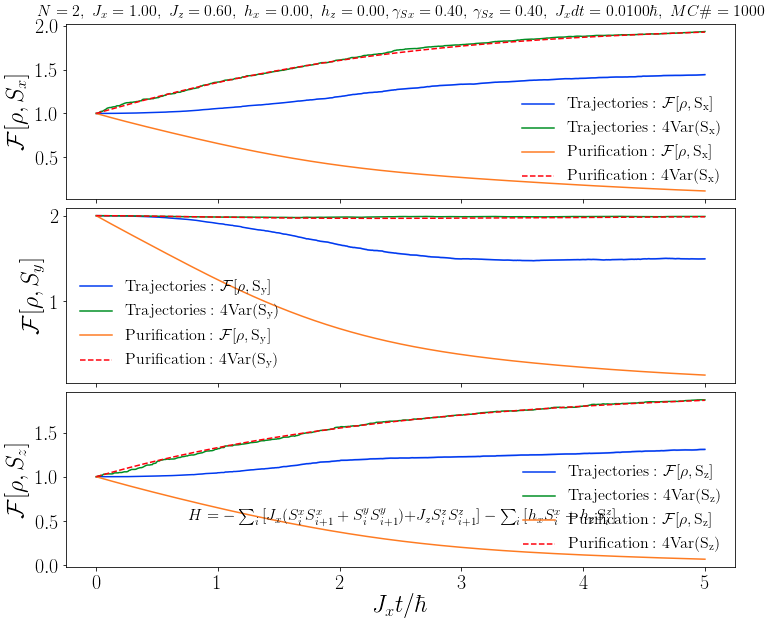

In [49]:
# Look at the Quantum Fisher Information
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True)
plt.subplots_adjust(hspace=0.05)

# QFI(Sx)
ax[0].plot(mcwf['Time'], np.real(mcwf['QFI_Sx_MCav']), '-', \
           label=r'$\rm{Trajectories:} ~ \mathcal{F}[\rho,S_{x}]$')
ax[0].fill_between(mcwf['Time'], np.real(mcwf['QFI_Sx_MCav']) - np.real(mcwf['QFI_Sx_MCsd']), \
                 np.real(mcwf['QFI_Sx_MCav']) + np.real(mcwf['QFI_Sx_MCsd']), alpha=0.3)
ax[0].plot(mcwf['Time'], 4*np.real(mcwf['SxSx_MCav'] - mcwf['Sx_MCav']**2), '-', \
           label=r'$\rm{Trajectories:} ~ 4\rm{Var}(S_{x})$')
ax[0].plot(pure['Time'], np.real(pure['QFI_Sx']), '-', \
           label=r'$\rm{Purification:} ~ \mathcal{F}[\rho,S_{x}]$')
ax[0].plot(pure['Time'], 4*np.real(pure['Var(Sx)']), '--', \
           label=r'$\rm{Purification:}  ~ 4\rm{Var}(S_{x})$')
ax[0].legend()
ax[0].set_ylabel(r'$\mathcal{F}[\rho,S_{x}]$')

# QFI(Sy)
ax[1].plot(mcwf['Time'], np.real(mcwf['QFI_Sy_MCav']), '-', \
           label=r'$\rm{Trajectories:} ~ \mathcal{F}[\rho,S_{y}]$')
ax[1].fill_between(mcwf['Time'], np.real(mcwf['QFI_Sy_MCav']) - np.real(mcwf['QFI_Sy_MCsd']), \
                 np.real(mcwf['QFI_Sy_MCav']) + np.real(mcwf['QFI_Sy_MCsd']), alpha=1.3)
ax[1].plot(mcwf['Time'], 4*np.real(mcwf['SySy_MCav'] - mcwf['Sy_MCav']**2), '-', \
           label=r'$\rm{Trajectories:} ~ 4\rm{Var}(S_{y})$')
ax[1].plot(pure['Time'], np.real(pure['QFI_Sy']), '-', \
           label=r'$\rm{Purification:} ~ \mathcal{F}[\rho,S_{y}]$')
ax[1].plot(pure['Time'], 4*np.real(pure['Var(Sy)']), '--', \
           label=r'$\rm{Purification:} ~ 4\rm{Var}(S_{y})$')
ax[1].legend()
ax[1].set_ylabel(r'$\mathcal{F}[\rho,S_{y}]$')

# QFI(Sz)
ax[2].plot(mcwf['Time'], np.real(mcwf['QFI_Sz_MCav']), '-', \
           label=r'$\rm{Trajectories:} ~ \mathcal{F}[\rho,S_{z}]$')
ax[2].fill_between(mcwf['Time'], np.real(mcwf['QFI_Sz_MCav']) - np.real(mcwf['QFI_Sz_MCsd']), \
                 np.real(mcwf['QFI_Sz_MCav']) + np.real(mcwf['QFI_Sz_MCsd']), alpha=2.3)
ax[2].plot(mcwf['Time'], 4*np.real(mcwf['SzSz_MCav'] - mcwf['Sz_MCav']**2), '-', \
           label=r'$\rm{Trajectories:} ~ 4\rm{Var}(S_{z})$')
ax[2].plot(pure['Time'], np.real(pure['QFI_Sz']), '-', \
           label=r'$\rm{Purification:} ~ \mathcal{F}[\rho,S_{z}]$')
ax[2].plot(pure['Time'], 4*np.real(pure['Var(Sz)']), '--', \
           label=r'$\rm{Purification:} ~ 4\rm{Var}(S_{z})$')
ax[2].legend()
ax[2].set_ylabel(r'$\mathcal{F}[\rho,S_{z}]$')



ax[2].set_xlabel(r'$J_{x}t/\hbar$')
ax[2].text(0.75, 0.45, r'$H = -\sum_{i} \Big[ J_{x}(S_{i}^{x}S_{i+1}^{x} + S_{i}^{y}S_{i+1}^{y}) + $' + \
           r'$J_{z}S_{i}^{z}S_{i+1}^{z}\Big] - \sum_{i}\Big[ h_{x}S^{x}_{i} + h_{z}S^{z}_{i} \Big]$', \
          fontsize=16)
ax[0].set_title(r'$N=%i,~J_{x}=%.2f,~J_{z}=%.2f,~h_{x}=%.2f,~h_{z}=%.2f,\gamma_{Sx}=%.2f,$' % \
                (p['N'],p['Jx'],p['Jz'],p['hx'],p['hz'],p['gamma_Sx']) + \
                r'$~\gamma_{Sz}=%.2f,~J_{x}dt=%.4f\hbar,~ MC\#=%i$' % \
                (p['gamma_Sz'],p['dt'],p['MCSamples']), fontsize=16);

path = 'plots/'
filename = 'XXZ_N%i_Jx%.2f_Jz%.2f_hx%.2f_hz%.2f_gSz%.2f_gSx%.2f_dt%.3f_tin%.2f_tfin%.2f_#%i' % \
            (p['N'], p['Jx'], p['Jz'], p['hx'], p['hz'], p['gamma_Sz'], p['gamma_Sx'], \
             p['dt'], p['t_initial'], p['t_final'], p['MCSamples'])
# plt.savefig(path + filename + '_Sz.pdf')